In [1]:
import os
import re
import sys
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from epitome.models import *
from epitome.functions import *
from epitome.viz import *
from epitome.constants import *

/home/eecs/jahnavis/miniconda/envs/EpitomeNewEnv2/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Results Path
early_stop_results_dir = "results/early_stop_results/"

early_stop_preds = os.path.join(early_stop_results_dir, "epitome_preds")
early_stop_models = os.path.join(early_stop_results_dir, "epitome_models")
early_stop_results = os.path.join(early_stop_results_dir, "epitome_results")

In [3]:
# checkpoint_auPRC = []
# checkpoint_auROC = []
# # Load in model_checkpoint to get the results from the "best" iteration
# for TF_dir in os.listdir(early_stop_models):
#     full_TF_dir = os.path.join(early_stop_models, TF_dir)
#     for p in os.listdir(full_TF_dir):
#         # Only want to look at model_checkpoint
#         splt = p.split("_")
#         if len(splt) == 12:
#             TF = splt[0]
#             train_iters = int(splt[3])
#             train_valid_iters = int(splt[5])
#             patience = int(splt[6])
#             if (patience == 3) & (train_valid_iters == 1000):
#                 model_checkpoint_p = os.path.join(full_TF_dir, p)
# #                 print(model_checkpoint_p)
#                 model_checkpoint_model = VLP(checkpoint= model_checkpoint_p)
#                 print("Testing %s" % TF)
#                 model_checkpoint_results = model_checkpoint_model.test(10000, calculate_metrics=True)
#                 checkpoint_auPRC.append(model_checkpoint_results['auPRC'])
#                 checkpoint_auROC.append(model_checkpoint_results['auROC'])

In [4]:
score_tfs = ["CTCF", "CEBPB", "CHD2", "EP300", "GABPA", 
             "JUND", "MAFK", "MAX", "MYC", "NRF1", "RAD21", 
             "REST", "RFX5", "SRF", "TAF1", "TBP", "USF2"]

# score_tfs = ["RFX5", "JUND", "CTCF", "REST", "SRF"]

# early_model_results = pd.DataFrame({'transcription_factor': score_tfs,
#                                     'auROC': checkpoint_auROC,
#                                     'auPRC': checkpoint_auPRC})
# early_model_results.to_csv(os.path.join(early_stop_results, "best_model_results.csv"), sep="\t")

In [5]:
# best_model_results = pd.read_csv(os.path.join(early_stop_results, "best_model_results.csv"), sep="\t")
# best_model_results.head()

In [9]:
results_df = pd.DataFrame(columns = ['transcription_factor', 'auROC', 'auPRC', 'iters_tested', 'iters_train_valid', 
                                     'iters_trained', 'min_delta', 'patience', 'train_time', 'valid_losses'])

for TF_dir in os.listdir(early_stop_results):
    full_TF_dir = os.path.join(early_stop_results, TF_dir)
    curr_TF = TF_dir.split("_")[0]
    if os.path.isdir(full_TF_dir): #and curr_TF in score_tfs:
        for p in os.listdir(full_TF_dir):
            # Only add new run right now
            splt = p.split("_")
            if ".ipynb" in p:
                continue
            if splt[-3] in ["12Aug2020", "16Aug2020", "02Aug2020"]: # in ["08Aug2020", "11Aug2020"]:
                res_csv = pd.read_csv(os.path.join(full_TF_dir, p), sep="\t")
                res_csv['validation_freq'] = 200
                if (splt[-3] == "16Aug2020"):
                    res_csv['valid_chr'] = 'chr22'
                else:
                    res_csv['valid_chr'] = 'chr1'
                res_csv['path_name'] = p
                results_df = results_df.append(res_csv, ignore_index=True)

results_df.shape

(1221, 21)

In [10]:
results_df.head()

,transcription_factor,auROC,auPRC,iters_tested,iters_train_valid,iters_trained,min_delta,patience,train_time,valid_losses,...,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq,valid_chr,path_name
0,CTCF,NaN,NaN,10000.0,1000.0,NaN,0.000,4.0,5400.125983,"[<tf.Tensor: shape=(), dtype=float32, numpy=40...",...,0.599673,0.598628,0.988518,0.989881,2000.0,5000.0,2800.0,200.0,chr1,CTCF_early_stop_5000_train_1000_4_0_02Aug2020_...
1,CTCF,NaN,NaN,10000.0,1000.0,NaN,0.001,4.0,5353.959328,"[<tf.Tensor: shape=(), dtype=float32, numpy=41...",...,0.593931,0.599687,0.989928,0.990561,2000.0,5000.0,2800.0,200.0,chr1,CTCF_early_stop_5000_train_1000_4_3_02Aug2020_...
2,CTCF,NaN,NaN,10000.0,1000.0,NaN,0.000,5.0,5478.227638,"[<tf.Tensor: shape=(), dtype=float32, numpy=35...",...,0.604128,0.609005,0.990056,0.991160,1800.0,5000.0,2800.0,200.0,chr1,CTCF_early_stop_5000_train_1000_5_0_02Aug2020_...
3,CTCF,NaN,NaN,10000.0,1000.0,NaN,0.001,5.0,10803.402701,"[<tf.Tensor: shape=(), dtype=float32, numpy=47...",...,0.616160,0.613670,0.991363,0.991238,4200.0,5000.0,5000.0,200.0,chr1,CTCF_early_stop_5000_train_1000_5_3_02Aug2020_...
4,CTCF,NaN,NaN,10000.0,5000.0,NaN,0.001,4.0,18893.819034,"[<tf.Tensor: shape=(), dtype=float32, numpy=38...",...,0.586709,0.596599,0.990068,0.990744,1800.0,5000.0,2600.0,200.0,chr1,CTCF_early_stop_5000_train_5000_4_3_02Aug2020_...


In [11]:
results_df.to_csv("results/early_stop_results/epitome_results/early_stop_results.csv")

In [27]:
for TF_dir in os.listdir(early_stop_results):
    full_TF_dir = os.path.join(early_stop_results, TF_dir)
    curr_TF = TF_dir.split("_")[0]
    if os.path.isdir(full_TF_dir):
        for p in os.listdir(full_TF_dir):
            # Only add new run right now
            if ".ipynb" in p:
                continue
            if p.split("_")[-3]== "27Jul2020":
                res_csv = pd.read_csv(os.path.join(full_TF_dir, p), sep="\t")
                res_csv['validation_freq'] = 1000
                results_df = results_df.append(res_csv, ignore_index=True)
results_df.shape

(448, 19)

In [7]:
results_df['auPRC_max'] = results_df[['auPRC_earlystop', 
                                      'auPRC_bestmodel']].max(axis=1)

In [8]:
results_df.head()

,transcription_factor,auROC,auPRC,iters_tested,iters_train_valid,iters_trained,min_delta,patience,train_time,valid_losses,Unnamed: 0,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq,auPRC_max
0,CTCF,NaN,NaN,10000.0,5000.0,NaN,0.0,4.0,19853.415130,"[<tf.Tensor: shape=(), dtype=float32, numpy=41...",0.0,0.574632,0.582745,0.990325,0.991000,2000.0,5000.0,2800.0,200.0,0.582745
1,CTCF,NaN,NaN,10000.0,5000.0,NaN,0.0,4.0,21056.735199,"[<tf.Tensor: shape=(), dtype=float32, numpy=44...",0.0,0.592399,0.587686,0.982794,0.988264,1800.0,5000.0,2600.0,200.0,0.592399
2,CTCF,NaN,NaN,10000.0,5000.0,NaN,0.0,4.0,22403.031258,"[<tf.Tensor: shape=(), dtype=float32, numpy=43...",0.0,0.602465,0.601736,0.989938,0.990575,2000.0,5000.0,2800.0,200.0,0.602465
3,CTCF,NaN,NaN,10000.0,5000.0,NaN,0.0,4.0,25144.797935,"[<tf.Tensor: shape=(), dtype=float32, numpy=40...",0.0,0.602142,0.598197,0.990205,0.990467,2000.0,5000.0,2800.0,200.0,0.602142
4,CTCF,NaN,NaN,10000.0,5000.0,NaN,0.0,4.0,25245.139495,"[<tf.Tensor: shape=(), dtype=float32, numpy=37...",0.0,0.602704,0.605548,0.990679,0.991221,2800.0,5000.0,3600.0,200.0,0.605548


In [91]:
results_df.groupby(['patience', 'min_delta', 'iters_train_valid']
                                             )[['auPRC_bestmodel', 'auPRC_earlystop']].describe()

auPRC_bestmodel                      \
                                               count      mean       std   
patience min_delta iters_train_valid                                       
3.0      0.00      5000.0                       40.0  0.486977  0.129840   
         0.01      5000.0                       40.0  0.476345  0.127787   
         0.10      5000.0                       40.0  0.458376  0.130914   
4.0      0.00      5000.0                       40.0  0.503074  0.128515   
         0.01      5000.0                       40.0  0.483161  0.130417   
         0.10      5000.0                       40.0  0.462691  0.132637   
5.0      0.00      5000.0                       40.0  0.493658  0.133642   
         0.01      5000.0                       40.0  0.490207  0.130060   
         0.10      5000.0                       40.0  0.457917  0.123819   

                                                                              \
                                           min       25%       50%       75%   
patience min_delta iters_train_valid                                           
3.0      0.00      5000.0             0.234351  0.422410  0.530710  0.587648   
         0.01      5000.0             0.261707  0.344038  0.512537  0.582665   
         0.10      5000.0             0.247260  0.322630  0.502460  0.569724   
4.0      0.00      5000.0             0.268177  0.432166  0.543633  0.605705   
         0.01      5000.0             0.241647  0.353729  0.531010  0.595247   
         0.10      5000.0             0.247983  0.329210  0.495204  0.587186   
5.0      0.00      5000.0             0.244358  0.374916  0.531032  0.605331   
         0.01      5000.0             0.253388  0.408875  0.526210  0.604657   
         0.10      5000.0             0.260545  0.336385  0.475951  0.563507   

                                               auPRC_earlystop            \
                                           max           count      mean   
patience min_delta iters_train_valid                                       
3.0      0.00      5000.0             0.642830            40.0  0.480344   
         0.01      5000.0             0.654933            40.0  0.482450   
         0.10      5000.0             0.633121            40.0  0.458036   
4.0      0.00      5000.0             0.671266            40.0  0.492946   
         0.01      5000.0             0.638708            40.0  0.483518   
         0.10      5000.0             0.650666            40.0  0.461342   
5.0      0.00      5000.0             0.668183            40.0  0.498170   
         0.01      5000.0             0.640446            40.0  0.489975   
         0.10      5000.0             0.624364            40.0  0.464481   

                                                                              \
                                           std       min       25%       50%   
patience min_delta iters_train_valid                                           
3.0      0.00      5000.0             0.139082  0.227823  0.390884  0.529978   
         0.01      5000.0             0.129976  0.250636  0.413062  0.526091   
         0.10      5000.0             0.128589  0.253258  0.321877  0.489968   
4.0      0.00      5000.0             0.144113  0.223536  0.421227  0.540769   
         0.01      5000.0             0.141942  0.231366  0.314486  0.523641   
         0.10      5000.0             0.147522  0.222985  0.288249  0.530165   
5.0      0.00      5000.0             0.144038  0.250359  0.379990  0.547571   
         0.01      5000.0             0.136645  0.235708  0.363078  0.546020   
         0.10      5000.0             0.140650  0.235803  0.308032  0.525020   

                                                          
                                           75%       max  
patience min_delta iters_train_valid                      
3.0      0.00      5000.0             0.591326  0.659281  
         0.01      5000.0             0.581783  0.649

In [92]:
results_df.groupby(['patience', 'min_delta', 'transcription_factor'])['train_time'].count()

patience  min_delta  transcription_factor
3.0       0.0        CEBPB                   5
                     CTCF                    5
                     JUND                    5
                     MAFK                    5
                     NRF1                    5
                                            ..
5.0       0.1        MAFK                    5
                     NRF1                    5
                     REST                    5
                     RFX5                    5
                     SRF                     5
Name: train_time, Length: 72, dtype: int64

In [93]:
results_df['transcription_factor'].value_counts()

CTCF     45
MAFK     45
JUND     45
REST     45
CEBPB    45
NRF1     45
SRF      45
RFX5     45
Name: transcription_factor, dtype: int64

In [81]:
results_df.groupby(['patience', 
                    'min_delta'])[['auPRC_bestmodel', 'auPRC_earlystop']].describe()

auPRC_bestmodel                                          \
                             count      mean       std       min       25%   
patience min_delta                                                           
3.0      0.00                 25.0  0.443551  0.140017  0.234351  0.286089   
         0.01                 25.0  0.430888  0.133060  0.261707  0.318209   
         0.10                 25.0  0.399273  0.127609  0.247260  0.295498   
4.0      0.00                 25.0  0.464955  0.144487  0.268177  0.310773   
         0.01                 25.0  0.436914  0.142098  0.241647  0.295637   
         0.10                 24.0  0.399577  0.125284  0.247983  0.296284   
5.0      0.00                 25.0  0.452846  0.147560  0.244358  0.298484   
         0.01                 25.0  0.452857  0.146106  0.253388  0.300377   
         0.10                 25.0  0.403838  0.121284  0.260545  0.306603   

                                                 auPRC_earlystop            \
                         50%       75%       max           count      mean   
patience min_delta                                                           
3.0      0.00       0.483701  0.570943  0.610948            25.0  0.425845   
         0.01       0.388314  0.556373  0.654933            25.0  0.435202   
         0.10       0.361204  0.521057  0.597995            25.0  0.400961   
4.0      0.00       0.494331  0.602155  0.671266            25.0  0.446869   
         0.01       0.437861  0.593534  0.622026            25.0  0.429617   
         0.10       0.342801  0.495044  0.599254            24.0  0.395972   
5.0      0.00       0.479429  0.603434  0.668183            25.0  0.452655   
         0.01       0.516209  0.588612  0.632564            25.0  0.445509   
         0.10       0.354830  0.521420  0.602307            25.0  0.406669   

                                                                                
                         std       min       25%       50%       75%       max  
patience min_delta                                                              
3.0      0.00       0.146899  0.227823  0.266571  0.461244  0.589153  0.606027  
         0.01       0.137670  0.250636  0.274257  0.470236  0.561012  0.600715  
         0.10       0.125539  0.253258  0.299401  0.361387  0.540227  0.594886  
4.0      0.00       0.161042  0.223536  0.270475  0.477318  0.597339  0.683422  
         0.01       0.151459  0.231366  0.280013  0.459416  0.585982  0.663624  
         0.10       0.152368  0.222985  0.266160  0.318697  0.560030  0.621813  
5.0      0.00       0.162193  0.250359  0.283902  0.485726  0.597782  0.746958  
         0.01       0.150016  0.235708  0.291683  0.507534  0.596228  0.617128  
         0.10       0.143848  0.235803  0.272525  0.372302  0.569391  0.607845

In [94]:
results_tf_df = results_df.groupby(["transcription_factor", 'patience', 'min_delta']).agg('mean').reset_index()
results_tf_df[(results_tf_df['patience'] == 4) &
              (results_tf_df['min_delta'] == 0)]

,transcription_factor,patience,min_delta,iters_tested,iters_train_valid,train_time,Unnamed: 0,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq
3,CEBPB,4.0,0.0,10000.0,5000.0,17022.247261,0.0,0.541010,0.557174,0.996230,0.996452,2680.0,5000.0,3480.0,200.0
12,CTCF,4.0,0.0,10000.0,5000.0,35194.044104,0.0,0.609844,0.613299,0.990846,0.991090,3480.0,5000.0,4240.0,200.0
21,JUND,4.0,0.0,10000.0,5000.0,21312.065534,0.0,0.329969,0.251132,0.996641,0.994890,3960.0,5000.0,4760.0,200.0
30,MAFK,4.0,0.0,10000.0,5000.0,18273.910209,0.0,0.528391,0.513145,0.997286,0.997255,2680.0,5000.0,3480.0,200.0
39,NRF1,4.0,0.0,10000.0,5000.0,20390.130241,0.0,0.630414,0.638908,0.996521,0.996489,4400.0,5000.0,4760.0,200.0
48,REST,4.0,0.0,10000.0,5000.0,14947.257905,0.0,0.279051,0.277786,0.995806,0.995916,2280.0,5000.0,3080.0,200.0
57,RFX5,4.0,0.0,10000.0,5000.0,17166.100205,0.0,0.511067,0.488700,0.997699,0.997682,2720.0,5000.0,3520.0,200.0
66,SRF,4.0,0.0,10000.0,5000.0,16315.085374,0.0,0.594842,0.603427,0.999386,0.999344,4640.0,5000.0,5000.0,200.0


In [95]:
tf_counts = results_df['transcription_factor'].value_counts()
complete_tfs = tf_counts.index[tf_counts == 8].tolist()

results_df_sub = results_df
# results_df_sub = results_df[results_df['transcription_factor'].isin(complete_tfs)]
earlystop_best_model = results_df_sub.groupby(['patience', 'min_delta', 'iters_train_valid', 'validation_freq']
                                             )[['auPRC_earlystop', 'auPRC_bestmodel', 
                                                'iters_trained_bestmodel']].agg(['median', 'mean', 'count'])

In [96]:
earlystop_best_model.columns = ['_'.join(col).strip() for col in earlystop_best_model.columns.values]
earlystop_best_model = earlystop_best_model.reset_index()

In [97]:
earlystop_best_model[earlystop_best_model['validation_freq'] == 200][
    ['auPRC_earlystop_mean', 'auPRC_bestmodel_mean', 'auPRC_earlystop_median', 'auPRC_bestmodel_median']].idxmax()

auPRC_earlystop_mean      6
auPRC_bestmodel_mean      3
auPRC_earlystop_median    6
auPRC_bestmodel_median    3
dtype: int64

In [98]:
earlystop_best_model.loc[[3, 6, 7]]

,patience,min_delta,iters_train_valid,validation_freq,auPRC_earlystop_median,auPRC_earlystop_mean,auPRC_earlystop_count,auPRC_bestmodel_median,auPRC_bestmodel_mean,auPRC_bestmodel_count,iters_trained_bestmodel_median,iters_trained_bestmodel_mean,iters_trained_bestmodel_count
3,4.0,0.00,5000.0,200.0,0.540769,0.492946,40,0.543633,0.503074,40,3000.0,3355.0,40
6,5.0,0.00,5000.0,200.0,0.547571,0.498170,40,0.531032,0.493658,40,3500.0,3550.0,40
7,5.0,0.01,5000.0,200.0,0.546020,0.489975,40,0.526210,0.490207,40,3400.0,3395.0,40


In [15]:
earlystop_best_model

,patience,min_delta,iters_train_valid,validation_freq,auPRC_earlystop_median,auPRC_earlystop_mean,auPRC_earlystop_count,auPRC_bestmodel_median,auPRC_bestmodel_mean,auPRC_bestmodel_count,iters_trained_bestmodel_median,iters_trained_bestmodel_mean,iters_trained_bestmodel_count
0,4.0,0.0,5000.0,200.0,0.543192,0.494796,410,0.544865,0.493525,410,4200.0,3528.470588,425


In [12]:
# earlystop_best_model[earlystop_best_model['validation_freq'] == 1000][
#     ['auPRC_earlystop_median', 'auPRC_bestmodel_median']].idxmax()
# earlystop_best_model.loc[[21,23]]

In [108]:
results_df['auPRC_earlystop'].agg(['mean', 'median'])

mean      0.494796
median    0.543192
Name: auPRC_earlystop, dtype: float64

In [105]:
base_res_sub['auPRC_earlystop'].agg(['mean', 'median'])

mean      0.489136
median    0.546737
Name: auPRC_earlystop, dtype: float64

In [104]:
base_res_hype_sub = base_res_sub[base_res_sub['transcription_factor']
                                 .isin(results_tf_df['transcription_factor'])]
base_res_hype_sub['auPRC_earlystop'].agg(['mean', 'median'])

mean      0.489238
median    0.532547
Name: auPRC_earlystop, dtype: float64

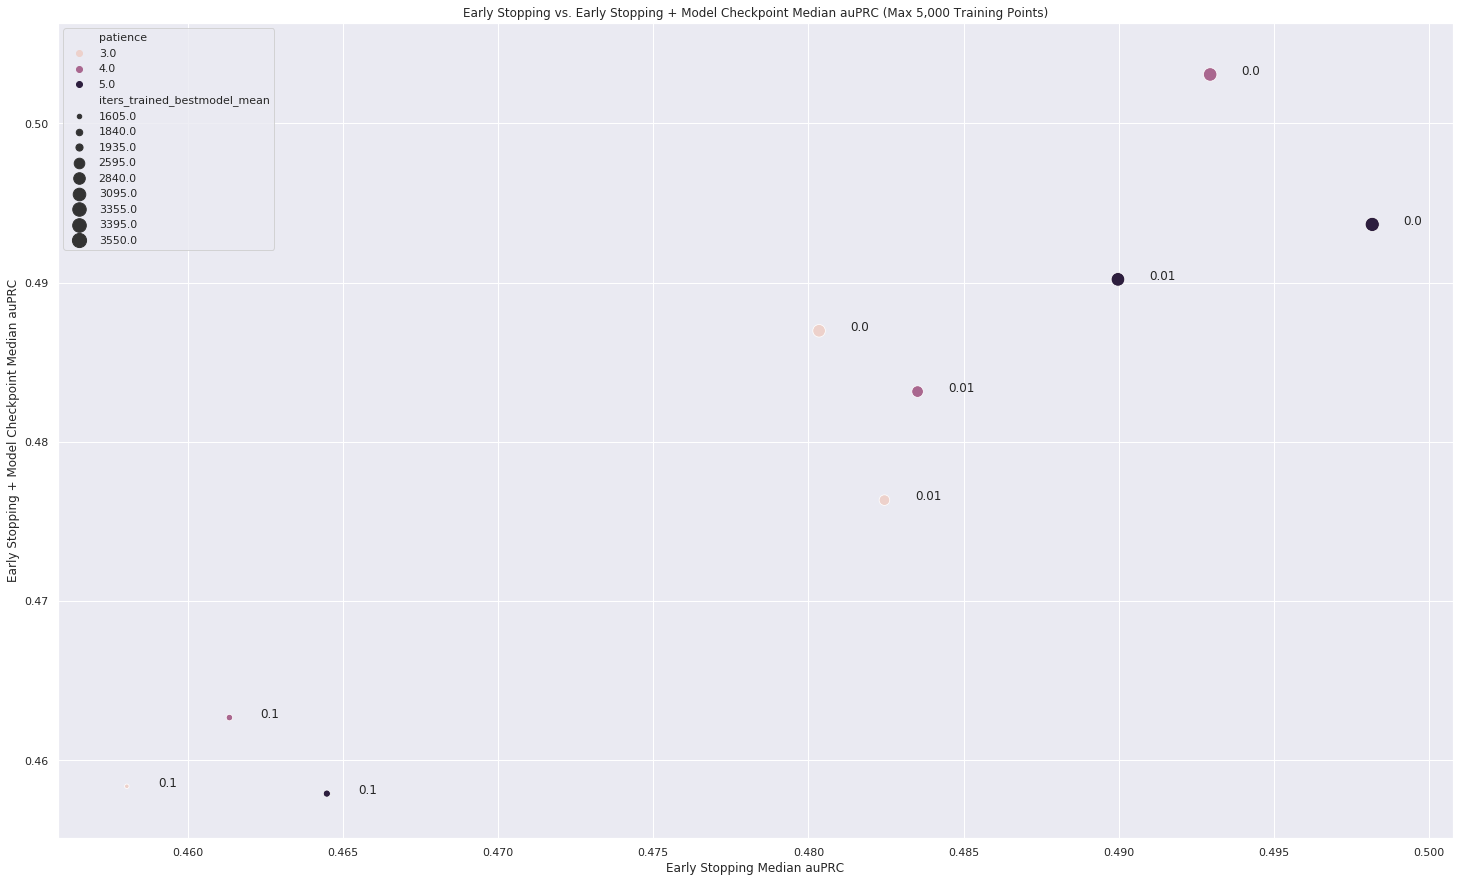

In [100]:
plt.figure(figsize=(25,15))
# x = np.linspace(0.58, .61, 100)
# sns.lineplot(x = x, y = x, color='red')

def label_point(x, y, val1, ax): #, val2, val3, ax):
    a = pd.concat({'x': x, 'y': y, 'val1': val1}, axis=1) #, 'val2': val2, 'val3': val3}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.001, point['y'], str(point['val1'])) # + "_" + str(point['val2']) + "_" + str(point['val3']))

# df_sub = best_param_df.merge(best_param_df, on="transcription_factor")
ax = sns.scatterplot(x = 'auPRC_earlystop_mean', 
                     y = 'auPRC_bestmodel_mean', 
                     size = 'iters_trained_bestmodel_mean',
                     hue = 'patience',
#                      palette=['green', 'black','dodgerblue','red'],
#                      palette="Set1",
                     sizes=(20, 200),
                     data=earlystop_best_model,
                     legend='full')

label_point(earlystop_best_model['auPRC_earlystop_mean'], 
            earlystop_best_model['auPRC_bestmodel_mean'],
#             earlystop_best_model['iters_train_valid'], 
#             earlystop_best_model['validation_freq'], 
            earlystop_best_model['min_delta'], 
            plt.gca())

ax.set(title="Early Stopping vs. Early Stopping + Model Checkpoint Median auPRC (Max 5,000 Training Points)",
       xlabel= "Early Stopping Median auPRC",
       ylabel= "Early Stopping + Model Checkpoint Median auPRC")
plt.legend()

In [10]:
best_param_df = results_df[(results_df['patience'] == 4) & 
                           (results_df['min_delta'] == 0) & 
                           (results_df['iters_train_valid'] == 1000) &
                           (results_df['validation_freq'] == 200)]

best_param_df2 = results_df[(results_df['patience'] == 3) &
                            (results_df['min_delta'] == 0.001) & 
                            (results_df['iters_train_valid'] == 1000) &
                            (results_df['validation_freq'] == 1000) &
                            (results_df['transcription_factor'].isin(best_param_df['transcription_factor'].unique()))]

In [27]:
best_param_df = results_df[(results_df['patience'] == 5) & 
                           (results_df['min_delta'] == 0) & 
                           (results_df['iters_train_valid'] == 5000) &
                           (results_df['validation_freq'] == 200)]
best_param_df = best_param_df.groupby('transcription_factor').median().reset_index() #.drop(['auROC', 'auPRC'], axis=1)

In [39]:
# best_param_df = results_df[(results_df['patience']==3) & 
#                            (results_df['min_delta']==0) & 
#                            (results_df['iters_train_valid'] == 1000)]
# best_param_df = best_param_df.merge(best_model_results, on="transcription_factor", suffixes=("_earlystop", "_modelcheck"))
# best_param_df

In [12]:
baseline_results = "results/early_stop_results/epitome_results/"

base_results_df = pd.DataFrame(columns = ['transcription_factor', 'auROC', 'auPRC', 'iters_tested', 'iters_train_valid', 
                                     'iters_trained', 'min_delta', 'patience', 'train_time', 'valid_losses'])

for TF_dir in os.listdir(baseline_results):
    full_TF_dir = os.path.join(baseline_results, TF_dir)
    curr_TF = TF_dir.split("_")[0]
    if os.path.isdir(full_TF_dir): #and curr_TF in score_tfs:
        for p in os.listdir(full_TF_dir):
            # Only add new run right now
            splt_path = p.split("_")
            if ".ipynb" in p:
                continue
            if (splt_path[-2] == "15Aug2020") and (splt_path[-5] == "train") and (splt_path[-4] == "chr1"): #"29Jul2020":
                res_csv = pd.read_csv(os.path.join(full_TF_dir, p), sep="\t")
                res_csv['validation_freq'] = 0
                res_csv['valid_chr'] = splt_path[-4]
                res_csv['path_name'] = p
#                 print(p)
                base_results_df = base_results_df.append(res_csv, ignore_index=True)
                
base_results_df['auPRC_earlystop'] = base_results_df['auPRC_earlystop'].fillna(0)

# base_results_median = base_results_df.groupby("transcription_factor")[['auPRC_earlystop']].mean().reset_index()
base_results_df.shape

(425, 19)

In [13]:
base_results_df.to_csv("results/early_stop_results/epitome_results/baseline_results.csv")

In [26]:
sample_valid_results = "results/early_stop_results/epitome_results/"

sample_valid_df = pd.DataFrame(columns = ['transcription_factor', 'auROC', 'auPRC', 'iters_tested', 'iters_train_valid', 
                                     'iters_trained', 'min_delta', 'patience', 'train_time', 'valid_losses'])

for TF_dir in os.listdir(sample_valid_results):
    full_TF_dir = os.path.join(sample_valid_results, TF_dir)
    curr_TF = TF_dir.split("_")[0]
    if os.path.isdir(full_TF_dir) and curr_TF in score_tfs:
        for p in os.listdir(full_TF_dir):
            # Only add new run right now
            if ".ipynb" in p:
                continue
            if (p.split("_")[-3] == "06Aug2020") and (p.split("_")[-6] == "sample"): #"29Jul2020":
                res_csv = pd.read_csv(os.path.join(full_TF_dir, p), sep="\t")
                res_csv['validation_freq'] = 200
                sample_valid_df = sample_valid_df.append(res_csv, ignore_index=True)
                
sample_valid_df['auPRC_earlystop'] = sample_valid_df['auPRC_earlystop'].fillna(0)

sample_valid_df.shape

(34, 19)

In [28]:
sample_valid_df.groupby("min_delta")[['auPRC_earlystop', 'auPRC_bestmodel']].describe()

auPRC_earlystop                                                    \
                    count      mean       std       min       25%       50%   
min_delta                                                                     
0.0                  17.0  0.483905  0.168662  0.148482  0.439459  0.502095   
0.1                  17.0  0.480030  0.162876  0.152472  0.362553  0.522729   

                              auPRC_bestmodel                                \
                75%       max           count      mean       std       min   
min_delta                                                                     
0.0        0.586500  0.749659            17.0  0.480834  0.160912  0.153096   
0.1        0.598975  0.728013            17.0  0.460871  0.168189  0.144794   

                                                   
                25%       50%       75%       max  
min_delta                                          
0.0        0.465804  0.516347  0.592997  0.716040  
0.1        0.315388  0.510556  0.579681  0.714613

In [37]:
results_df[results_df['iters_train_valid'] == 0]

,transcription_factor,auROC,auPRC,iters_tested,iters_train_valid,iters_trained,min_delta,patience,train_time,valid_losses,Unnamed: 0,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq,auPRC_max


In [31]:
# Load saved DF
# df_p = os.path.join(internals_results_dir, "TF_results.csv")
df_p = os.path.join("results/internals_results/", "model_results.csv")
df = pd.read_csv(df_p)
# Clean missing values 
df_cleaned = df.replace("DNE", 0)
df_cleaned = df_cleaned.fillna(0)

df_cleaned['No Early auPRC'] = df_cleaned['No Early auPRC'].astype(float)
df_cleaned['No Early auROC'] = df_cleaned['No Early auROC'].astype(float)

df_cleaned['Early 1000 auPRC'] = df_cleaned['Early 1000 auPRC'].astype(float)
df_cleaned['Early 5000 auPRC'] = df_cleaned['Early 5000 auPRC'].astype(float)

df_cleaned['Early 1000 Train Iters'] = df_cleaned['Early 1000 Train Iters'].astype(float)
df_cleaned['Early 5000 Train Iters'] = df_cleaned['Early 5000 Train Iters'].astype(float)
df_cleaned.head()

,Unnamed: 0,TF,No Early auROC,No Early auPRC,No Early Train Iters,Early 1000 auROC,Early 1000 auPRC,Early 1000 Train Iters,Early 5000 auROC,Early 5000 auPRC,Early 5000 Train Iters,No Early 15000 auROC,No Early 15000 auPRC,No Early 15000 Train Iters,"Early 1000, 15000 auROC","Early 1000, 15000 auPRC","Early 1000, 15000 Train Iters","Early 5000, 15000 auROC","Early 5000, 15000 auPRC","Early 5000, 15000 Train Iters"
0,0,ZNF384,0.999600,0.528571,4999.0,0.999767,0.609524,3000.0,0.999667,0.555556,4999.0,0.999800,0.633333,15000.0,0.998166,0.388580,0,0.998733,0.410534,9000.0
1,1,ZNF274,0.000000,0.000000,4999.0,0.000000,0.000000,4000.0,0.000000,0.000000,4000.0,0.000000,0.000000,15000.0,0.000000,0.000000,0,0.000000,0.000000,5000.0
2,2,ZNF24,0.997793,0.594773,4999.0,0.998000,0.615453,4999.0,0.998016,0.632137,4999.0,0.998887,0.766671,15000.0,0.998696,0.697981,0,0.998251,0.663599,8000.0
3,3,ZNF143,0.996534,0.570652,4999.0,0.996821,0.565575,3000.0,0.996774,0.575012,4999.0,0.997529,0.659624,15000.0,0.997254,0.590629,0,0.997207,0.593448,11000.0
4,4,ZKSCAN1,0.997054,0.676653,4999.0,0.996218,0.641741,4000.0,0.997249,0.683770,4999.0,0.996501,0.707785,15000.0,0.997091,0.681156,0,0.997082,0.701234,11000.0


In [32]:
# early_stop_tfs = results_df['transcription_factor'].unique()
no_early_results_df_15000 = df_cleaned[['TF', 'No Early 15000 auROC','No Early 15000 auPRC', 
                                        'No Early 15000 Train Iters']]
no_early_results_df_15000.columns = ['transcription_factor', 'auROC', 'auPRC', 'iters_trained']

no_early_results_df_5000 = df_cleaned[['TF', 'No Early auROC',
                                       'No Early auPRC', 'No Early Train Iters']]
no_early_results_df_5000.columns = ['transcription_factor', 'auROC', 'auPRC', 'iters_trained']

no_early_results_df_15000.shape, no_early_results_df_5000.shape

((85, 4), (85, 4))

In [13]:
plt.figure(figsize=(25,15))

x = np.linspace(0, 1, 100)
sns.lineplot(x = x, y = x, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

df_sub = no_early_results_df.merge(best_param_df, on="transcription_factor")
ax = sns.scatterplot(x = 'auPRC_x', 
                     y = 'auPRC_y', 
                     size = "iters_trained_y",
                     data=df_sub)

label_point(df_sub['auPRC_x'], 
            df_sub['auPRC_y'],
            df_sub['transcription_factor'], 
            plt.gca())  

ax.set(title="Baseline vs. Early Stopping auPRC (Max 15,000 Training Points)",
       xlabel= "Baseline auPRC (Trained on 15,000 points)",
       ylabel= "Early Stopping auPRC (1,000 Train Valid Points)")
plt.legend(title="Iters Trained")

No handles with labels found to put in legend.


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


ValueError: cannot convert float NaN to integer

<Figure size 1800x1080 with 1 Axes>

In [50]:
df_sub.sort_values('transcription_factor')

,transcription_factor,auROC_base,auPRC_base,iters_trained_base,auROC_idk,auPRC_idk,iters_tested,iters_train_valid,iters_trained_idk,min_delta,...,Unnamed: 0,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq,auPRC_max
4,CTCF,0.989541,0.609688,15000.0,NaN,NaN,10000.0,1000.0,NaN,0.0,...,0.0,0.599903,0.603291,0.989338,0.990109,1800.0,5000.0,2600.0,200.0,0.603291
3,REST,0.996460,0.333550,15000.0,NaN,NaN,10000.0,1000.0,NaN,0.0,...,0.0,0.280975,0.262257,0.996014,0.996105,2400.0,5000.0,3200.0,200.0,0.280975
2,SRF,0.998943,0.537554,15000.0,NaN,NaN,10000.0,1000.0,NaN,0.0,...,0.0,0.577601,0.537348,0.999433,0.999377,4800.0,5000.0,5000.0,200.0,0.577601
1,TAF1,0.996942,0.622551,15000.0,NaN,NaN,10000.0,1000.0,NaN,0.0,...,0.0,0.715829,0.781500,0.998978,0.999326,2200.0,5000.0,3000.0,200.0,0.781500
0,USF2,0.997902,0.670149,15000.0,NaN,NaN,10000.0,1000.0,NaN,0.0,...,0.0,0.606511,0.591552,0.997694,0.997837,3200.0,5000.0,4000.0,200.0,0.606511


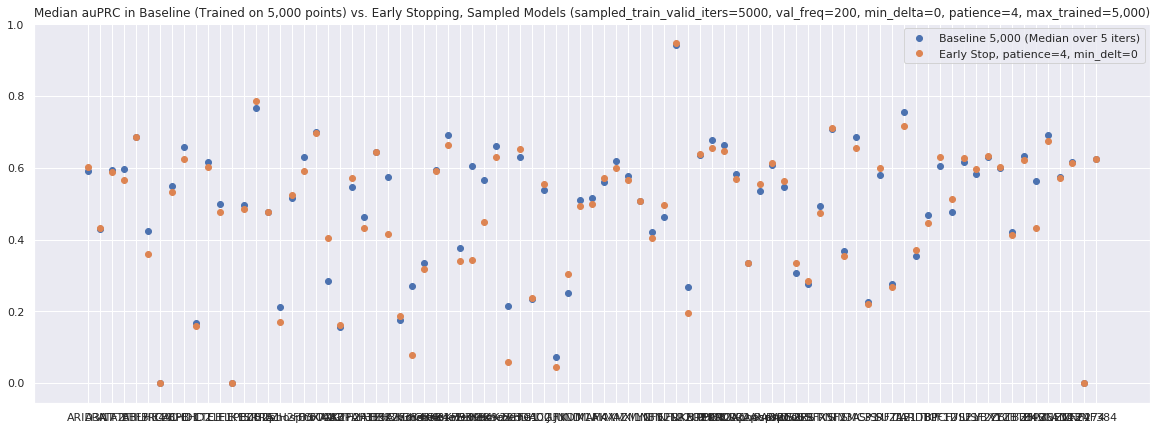

In [9]:
plt.figure(figsize=(20,7))

results_tf_df = results_df.groupby(["transcription_factor", 'patience', 
                                    'min_delta']).agg('median').reset_index()
results_tf_df = results_tf_df.fillna(0)
# results_tf_df = results_tf_df[results_tf_df['transcription_factor'].isin(score_tfs)]
results_tf_df = results_tf_df.sort_values("transcription_factor")

base_results_median = base_results_df.groupby("transcription_factor")[['auPRC_earlystop']
                                                                     ].median().reset_index()
base_res_sub = base_results_median
# base_res_sub = base_results_median[base_results_median['transcription_factor'].isin(score_tfs)]
base_res_sub = base_res_sub.sort_values('transcription_factor')

x = np.arange(results_tf_df.shape[0])

# plt.scatter(x, no_early_results_sub_15000['auPRC'], label= 'Baseline 15,000')
plt.scatter(x, base_res_sub['auPRC_earlystop'], label= 'Baseline 5,000 (Median over 5 iters)')
plt.scatter(x, results_tf_df['auPRC_bestmodel'], label= 'Early Stop, patience=4, min_delt=0')

plt.xticks(x, labels=results_tf_df['transcription_factor'])
plt.title("Median auPRC in Baseline (Trained on 5,000 points) vs. Early Stopping, Sampled Models (sampled_train_valid_iters=5000, val_freq=200, min_delta=0, patience=4, max_trained=5,000)")
plt.legend();

In [41]:
earlystop_greater = results_tf_df['auPRC_earlystop'] > base_res_sub['auPRC_earlystop']
early_greater_ind = earlystop_greater[earlystop_greater == True].index
early_greater_tfs = results_tf_df['transcription_factor'].loc[early_greater_ind].tolist()
len(early_greater_tfs)

37

In [82]:
res_diff = results_tf_df['auPRC_earlystop'] - base_res_sub['auPRC_earlystop']
base_diff = base_res_sub['auPRC_earlystop'] - results_tf_df['auPRC_earlystop']
res_diff[res_diff > 0.01].shape, base_diff[base_diff > 0.01].shape

((12,), (29,))

In [73]:
stopped_diff = stopped_early['auPRC_earlystop'] - base_res_sub['auPRC_earlystop']
stopped_diff[stopped_diff > 0.001].shape

(11,)

In [52]:
stopped_early = results_tf_df[results_tf_df['iters_trained_total'] != 5000]
stopped_early_tfs = stopped_early['transcription_factor'].tolist()
base_res_sub = base_res_sub[base_res_sub['transcription_factor'].isin(stopped_early_tfs)]
print(base_res_sub.shape)
# stopped_early['auPRC_earlystop'] > base_res_sub['auPRC_earlystop']
earlystop_auPRC = stopped_early['auPRC_earlystop'], base_res_sub['auPRC_earlystop']
base_auPRC = 

(40, 2)


,transcription_factor,patience,min_delta,iters_tested,iters_train_valid,train_time,Unnamed: 0,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq
9,CHD2,4.0,0.0,10000.0,5000.0,16003.174869,0.0,0.157725,0.167157,0.998966,0.999033,2800.0,5000.0,3600.0,200.0
26,H3K27me3,4.0,0.0,10000.0,5000.0,20534.864862,0.0,0.186214,0.183944,0.693022,0.690059,1600.0,5000.0,2400.0,200.0
29,H3K4me2,4.0,0.0,10000.0,5000.0,20894.396187,0.0,0.591252,0.594504,0.951907,0.950571,2000.0,5000.0,2800.0,200.0
40,JUND,4.0,0.0,10000.0,5000.0,19585.712018,0.0,0.304365,0.268672,0.996748,0.995097,3600.0,5000.0,4400.0,200.0
42,MAFK,4.0,0.0,10000.0,5000.0,18485.569358,0.0,0.498842,0.523139,0.997153,0.997387,2600.0,5000.0,3400.0,200.0
43,MAX,4.0,0.0,10000.0,5000.0,16964.607545,0.0,0.572567,0.568143,0.995142,0.995202,3000.0,5000.0,3800.0,200.0
56,POLR2AphosphoS5,4.0,0.0,10000.0,5000.0,19623.354549,0.0,0.553870,0.553667,0.995801,0.995844,3400.0,5000.0,4200.0,200.0
57,RAD21,4.0,0.0,10000.0,5000.0,13977.814010,0.0,0.612949,0.607669,0.996171,0.996224,2000.0,5000.0,2800.0,200.0
59,RCOR1,4.0,0.0,10000.0,5000.0,15190.755645,0.0,0.335410,0.313721,0.997535,0.997250,2600.0,5000.0,3400.0,200.0
74,USF2,4.0,0.0,10000.0,5000.0,18666.505983,0.0,0.597382,0.598319,0.997706,0.997744,3200.0,5000.0,4000.0,200.0


In [39]:
results_tf_df[(results_tf_df['iters_trained_total'] == 5000) &
              (results_tf_df['transcription_factor'].isin(early_greater_tfs))].shape

(25, 15)

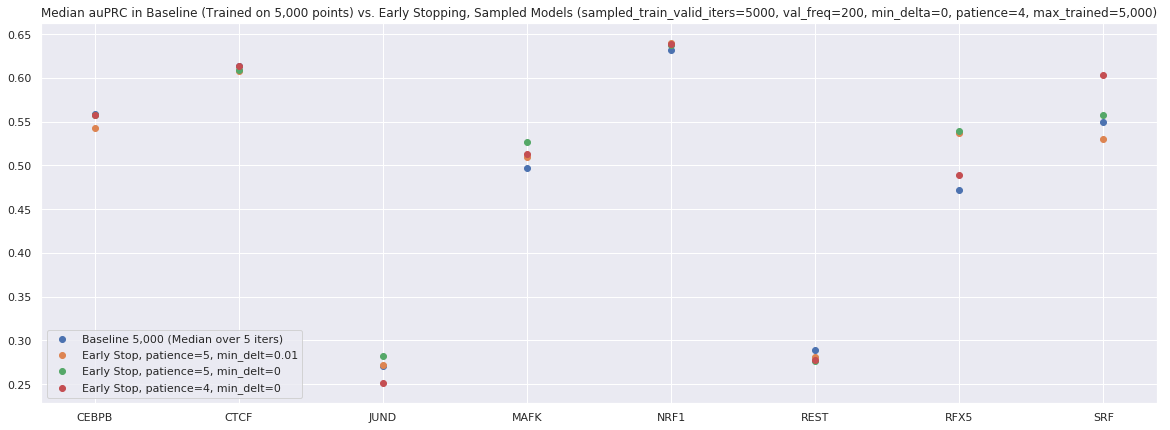

In [21]:
plt.figure(figsize=(20,7))

results_tf_df = results_df.groupby(["transcription_factor", 'patience', 'min_delta']).agg('mean').reset_index()

best_param_sub = results_tf_df[(results_tf_df['patience'] == 4) &
                               (results_tf_df['min_delta'] == 0)]
# best_param_sub = best_param_df[best_param_df['transcription_factor'].isin(score_tfs)]
best_param_sub = best_param_sub.sort_values('transcription_factor')

best_param_sub2 = results_tf_df[(results_tf_df['patience'] == 4) &
                               (results_tf_df['min_delta'] == 0.01)]
best_param_sub2 = best_param_sub2.sort_values('transcription_factor')

best_param_sub3 = results_tf_df[(results_tf_df['patience'] == 4) &
                               (results_tf_df['min_delta'] == 0.1)]
best_param_sub3 = best_param_sub3.sort_values('transcription_factor')

best_param_sub4 = results_tf_df[(results_tf_df['patience'] == 5) &
                               (results_tf_df['min_delta'] == 0.01)]
best_param_sub4 = best_param_sub4.sort_values('transcription_factor')

best_param_sub5 = results_tf_df[(results_tf_df['patience'] == 5) &
                               (results_tf_df['min_delta'] == 0)]
best_param_sub5 = best_param_sub5.sort_values('transcription_factor')

best_param_sub6 = results_tf_df[(results_tf_df['patience'] == 5) &
                               (results_tf_df['min_delta'] == 0.1)]
best_param_sub6 = best_param_sub6.sort_values('transcription_factor')

best_param_sub7 = results_tf_df[(results_tf_df['patience'] == 3) &
                               (results_tf_df['min_delta'] == 0.1)]
best_param_sub7 = best_param_sub7.sort_values('transcription_factor')


# base_res_sub = base_results_df[base_results_df['transcription_factor'].isin(score_tfs)]
# base_res_sub = base_res_sub.sort_values('transcription_factor')
best_tfs = best_param_sub['transcription_factor'].tolist()
base_res_sub = base_results_median[base_results_median['transcription_factor'].isin(best_tfs)]
base_res_sub = base_res_sub.sort_values('transcription_factor')

# sample_valid_df_0 = sample_valid_df[sample_valid_df['min_delta'] == 0].sort_values('transcription_factor')
# sample_valid_df_1 = sample_valid_df[sample_valid_df['min_delta'] == 0.1].sort_values('transcription_factor')
# no_early_results_sub_15000 = no_early_results_df_15000[
#     no_early_results_df_15000['transcription_factor'].isin(score_tfs)]
# no_early_results_sub_15000 = no_early_results_sub_15000.sort_values('transcription_factor')

x = np.arange(best_param_sub.shape[0])

# plt.scatter(x, no_early_results_sub_15000['auPRC'], label= 'Baseline 15,000')
plt.scatter(x, base_res_sub['auPRC_earlystop'], label= 'Baseline 5,000 (Median over 5 iters)')
plt.scatter(x, best_param_sub4['auPRC_earlystop'], label= 'Early Stop, patience=5, min_delt=0.01')
plt.scatter(x, best_param_sub5['auPRC_earlystop'], label= 'Early Stop, patience=5, min_delt=0')
plt.scatter(x, best_param_sub['auPRC_earlystop'], label= 'Early Stop, patience=4, min_delt=0')
# plt.scatter(x, best_param_sub2['auPRC_earlystop'], label= 'Early Stop, patience=4, min_delt=0.01')
# plt.scatter(x, best_param_sub3['auPRC_earlystop'], label= 'Early Stop, patience=4, min_delt=0.1')
# plt.scatter(x, best_param_sub3['auPRC_earlystop'], label= 'Early Stop, patience=5, min_delt=0')
# plt.scatter(x, best_param_sub7['auPRC_earlystop'], label= 'Early Stop, patience=3, min_delt=0.1')
# plt.scatter(x, best_param_sub3['auPRC_earlystop'], label= 'Early Stop, patience=4, min_delt=0.1')
# plt.scatter(x, best_param_sub6['auPRC_earlystop'], label= 'Early Stop, patience=5, min_delt=0.1')

# plt.scatter(x, sample_valid_df_0['auPRC_earlystop'], label= 'Early Stop (Sample Valid)')
# plt.scatter(x, sample_valid_df_1['auPRC_earlystop'], label= 'Early Stop (Sample Valid, min_delt=0.1, patience=4)')

# plt.scatter(x, best_param_sub['auPRC_bestmodel'], label= 'Best Model')

plt.xticks(x, labels=best_param_sub['transcription_factor'])
plt.title("Median auPRC in Baseline (Trained on 5,000 points) vs. Early Stopping, Sampled Models (sampled_train_valid_iters=5000, val_freq=200, min_delta=0, patience=4, max_trained=5,000)")
plt.legend();


No handles with labels found to put in legend.


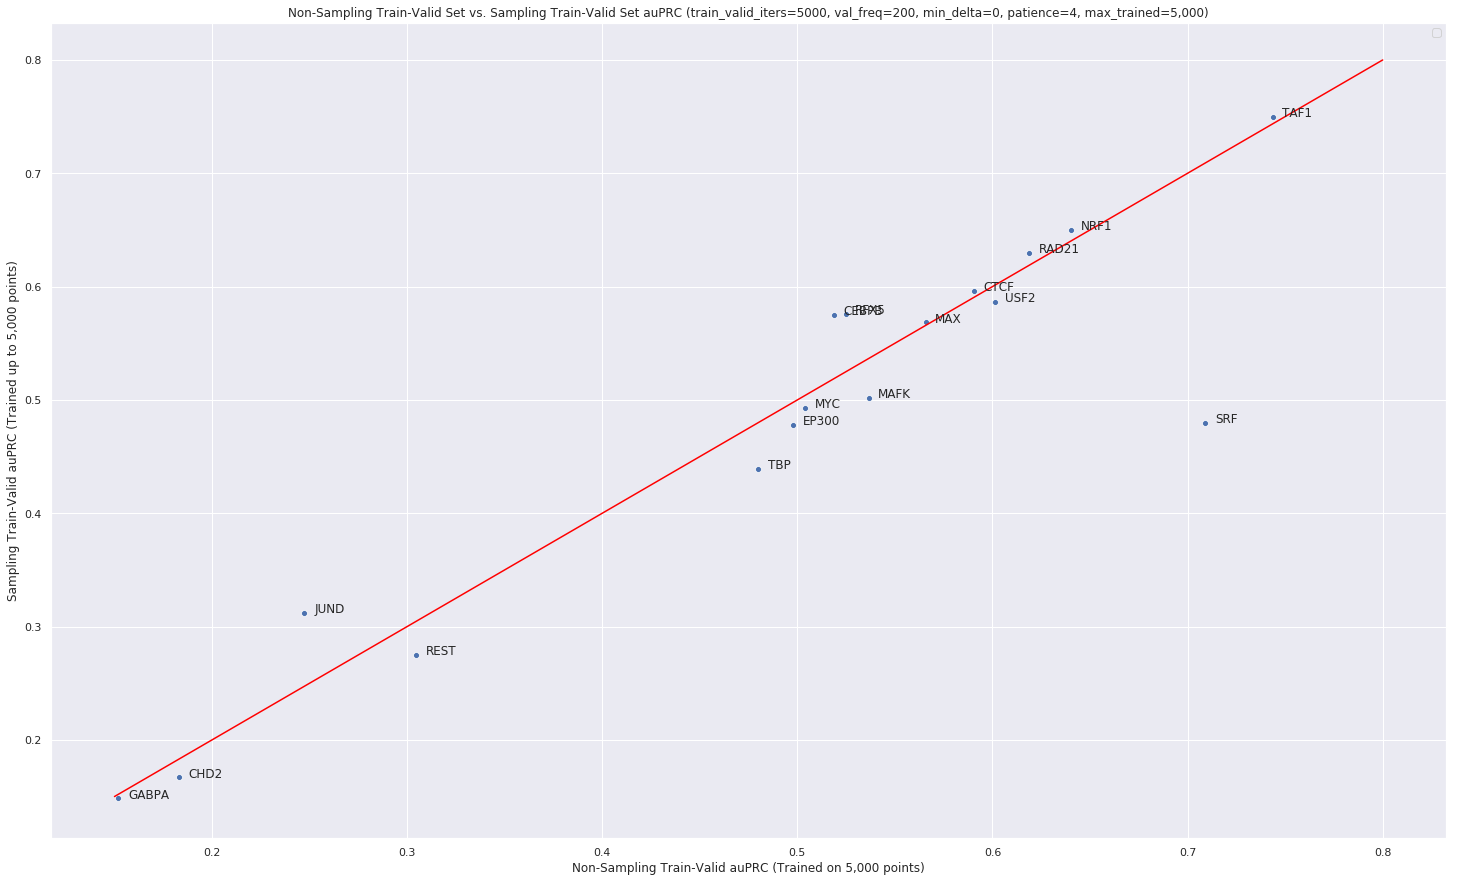

In [59]:
plt.figure(figsize=(25,15))
x = np.linspace(0.15, 0.8, 100)
sns.lineplot(x = x, y = x, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.005, point['y'], str(point['val']))

# df_sub = best_param_df.merge(best_param_df, on="transcription_factor")
ax = sns.scatterplot(best_param_sub['auPRC_earlystop'].tolist(), 
                sample_valid_df_0['auPRC_earlystop'].tolist())
#                 size = best_param_sub['iters_trained_bestmodel'],
#                      hue = 'patience',
#                      palette=['green', 'black','dodgerblue','red'],
#                      palette="Set1",
#                 sizes=(20, 100))
#                      data=earlystop_best_model,
#                      legend='full')

label_point(best_param_sub['auPRC_earlystop'].reset_index()['auPRC_earlystop'], 
            sample_valid_df_0['auPRC_earlystop'].reset_index()['auPRC_earlystop'],
            sample_valid_df_0['transcription_factor'].reset_index()['transcription_factor'], 
            plt.gca())

ax.set(title="Non-Sampling Train-Valid Set vs. Sampling Train-Valid Set auPRC (train_valid_iters=5000, val_freq=200, min_delta=0, patience=4, max_trained=5,000)",
       xlabel= "Non-Sampling Train-Valid auPRC (Trained on 5,000 points)",
       ylabel= "Sampling Train-Valid auPRC (Trained up to 5,000 points)")
plt.legend()

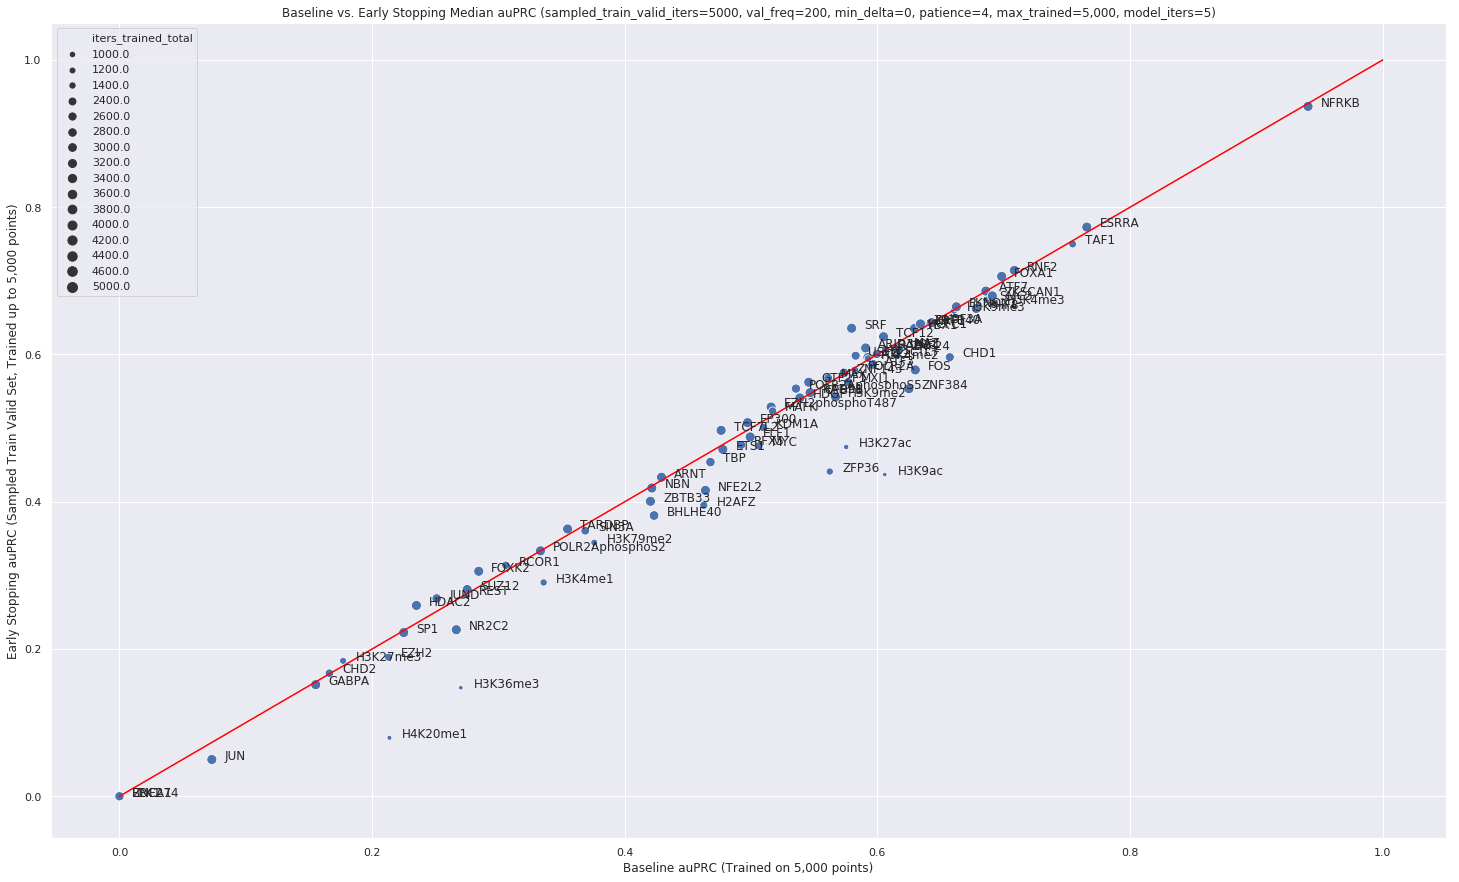

In [10]:
plt.figure(figsize=(25,15))
x = np.linspace(0, 1, 100)
sns.lineplot(x = x, y = x, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))

ax = sns.scatterplot(base_res_sub['auPRC_earlystop'].tolist(), 
                results_tf_df['auPRC_earlystop'].tolist(),
                size = results_tf_df['iters_trained_total'],
                sizes=(20, 100),
                legend='full')

label_point(base_res_sub['auPRC_earlystop'].reset_index()['auPRC_earlystop'], 
            results_tf_df['auPRC_earlystop'].reset_index()['auPRC_earlystop'],
            results_tf_df['transcription_factor'].reset_index()['transcription_factor'], 
            plt.gca())

ax.set(title="Baseline vs. Early Stopping Median auPRC (sampled_train_valid_iters=5000, val_freq=200, min_delta=0, patience=4, max_trained=5,000, model_iters=5)",
       xlabel= "Baseline auPRC (Trained on 5,000 points)",
       ylabel= "Early Stopping auPRC (Sampled Train Valid Set, Trained up to 5,000 points)")
plt.legend();

In [27]:
low_perf_tfs = ["H4K20me1", "H3K36me3", "H3K9ac", "H3K27ac", 
                "ZFP36", "H3K9me2", "H2AFZ", "H3K4me1", "H3K79me2"] #"BHLE40"]
results_tf_df[results_tf_df['transcription_factor'].isin(low_perf_tfs)].shape

(9, 15)

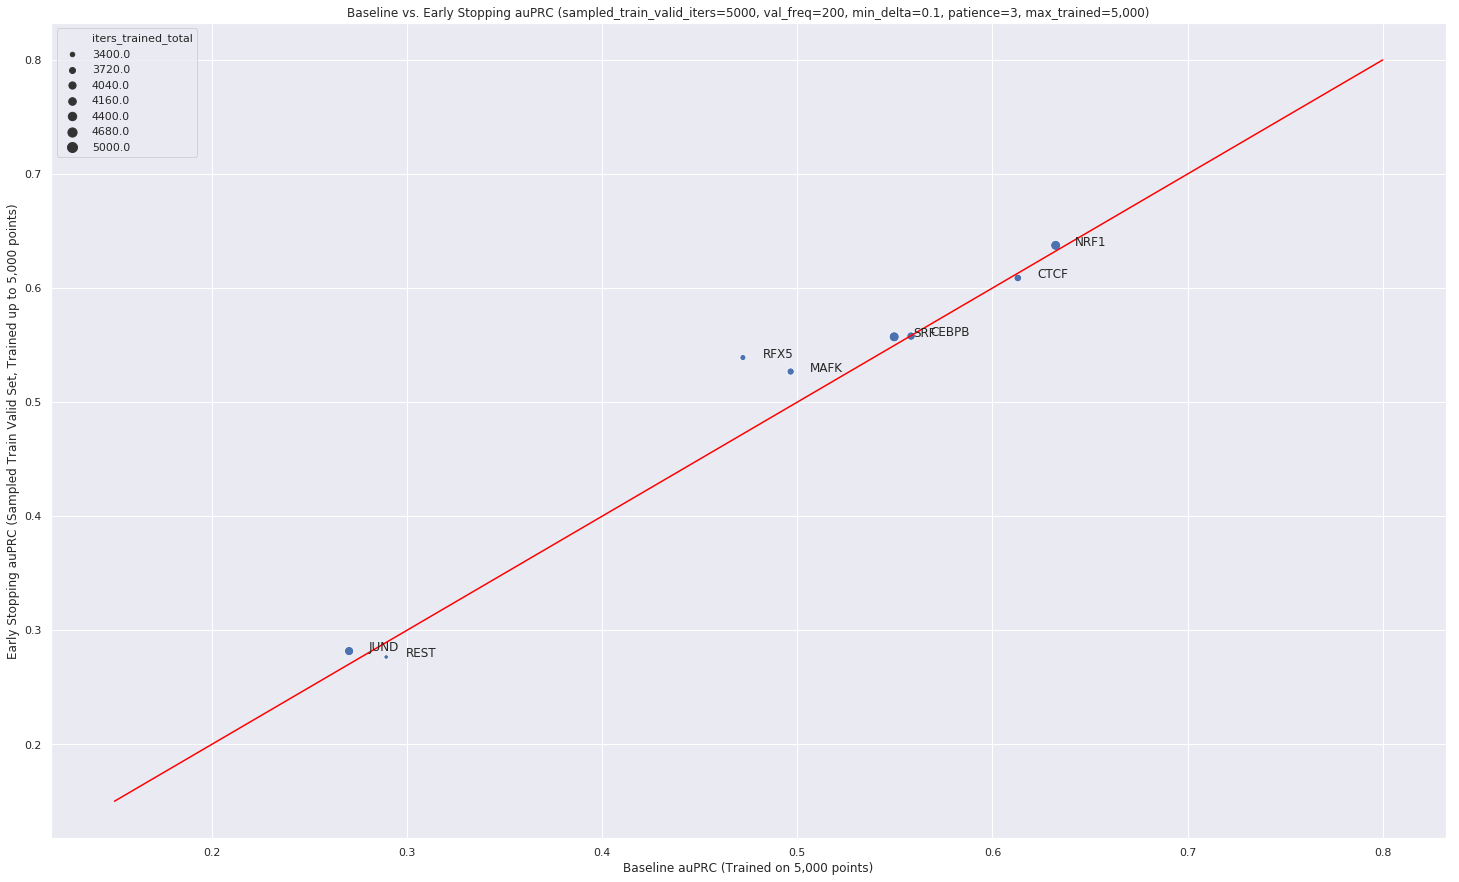

In [22]:
plt.figure(figsize=(25,15))
x = np.linspace(0.15, 0.8, 100)
sns.lineplot(x = x, y = x, color='red')

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.01, point['y'], str(point['val']))

# df_sub = best_param_df.merge(best_param_df, on="transcription_factor")
ax = sns.scatterplot(base_res_sub['auPRC_earlystop'].tolist(), 
                best_param_sub5['auPRC_earlystop'].tolist(),
                size = best_param_sub5['iters_trained_total'],
#                      hue = 'patience',
#                      palette=['green', 'black','dodgerblue','red'],
#                      palette="Set1",
                sizes=(20, 100),
#                      data=earlystop_best_model,
                     legend='full')

label_point(base_res_sub['auPRC_earlystop'].reset_index()['auPRC_earlystop'], 
            best_param_sub5['auPRC_earlystop'].reset_index()['auPRC_earlystop'],
            best_param_sub5['transcription_factor'].reset_index()['transcription_factor'], 
            plt.gca())

ax.set(title="Baseline vs. Early Stopping auPRC (sampled_train_valid_iters=5000, val_freq=200, min_delta=0.1, patience=3, max_trained=5,000)",
       xlabel= "Baseline auPRC (Trained on 5,000 points)",
       ylabel= "Early Stopping auPRC (Sampled Train Valid Set, Trained up to 5,000 points)")
plt.legend();

In [29]:
best_param_sub[['transcription_factor','iters_trained_total']]

,transcription_factor,iters_trained_total
15,CEBPB,5000.0
20,CHD2,3400.0
4,CTCF,2600.0
31,EP300,5000.0
37,GABPA,5000.0
45,JUND,3200.0
53,MAFK,4000.0
63,MAX,4800.0
68,MYC,2600.0
77,NRF1,5000.0


In [43]:
base_results_df = base_results_df.sort_values("transcription_factor")
best_param_df = best_param_df.sort_values("transcription_factor")
df_cleaned = df_cleaned.sort_values('TF')

base_results_df.shape, best_param_df.shape, df_cleaned.shape

((85, 17), (81, 20), (85, 20))

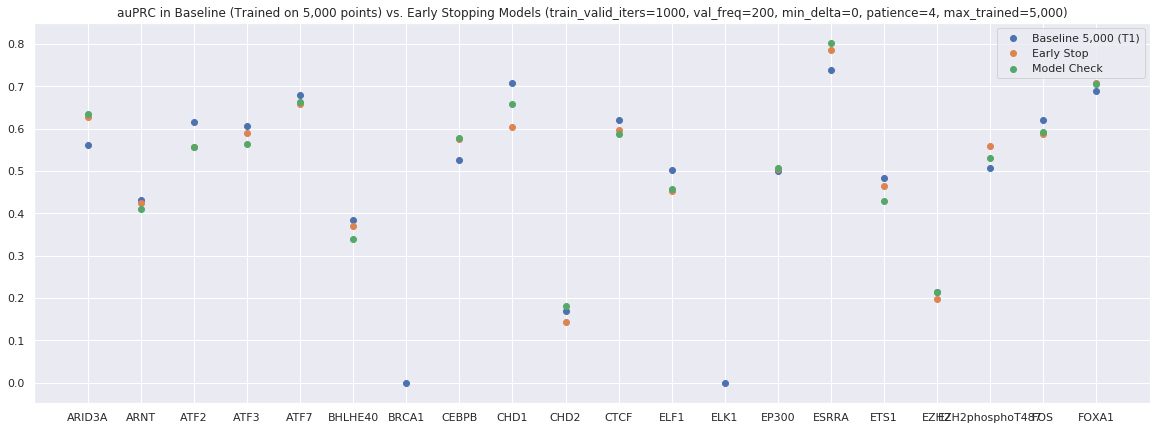

In [68]:
plt.figure(figsize=(20,7))
# df_sub = no_early_results_df.merge(best_param_df, on="transcription_factor", 
#                                    suffixes=('_base', '_idk')).sort_values("transcription_factor")
best_param_df = best_param_df.sort_values("transcription_factor")
early_stop_tfs = best_param_df['transcription_factor']
base_results_df = base_results_df[base_results_df['transcription_factor'].isin(early_stop_tfs)]
base_results_df = base_results_df.sort_values("transcription_factor")
no_early_results_df_5000 = no_early_results_df_5000[
    no_early_results_df_5000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_5000 = no_early_results_df_5000.sort_values('transcription_factor')
no_early_results_df_15000 = no_early_results_df_15000[
    no_early_results_df_15000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_15000 = no_early_results_df_15000.sort_values('transcription_factor')

start_ind, end_ind = 0, 20
x = np.arange(end_ind - start_ind)

# plt.scatter(x, df_sub['auPRC_base'], label= 'Baseline 15,000')
plt.scatter(x, base_results_df['auPRC_earlystop'][start_ind : end_ind], label= 'Baseline 5,000 (T1)')
# plt.scatter(x, no_early_results_df_5000['auPRC'][start_ind : end_ind], label= 'Baseline 5,000 (T2)')
# plt.scatter(x, no_early_results_df_15000['auPRC'][start_ind : end_ind], label= 'Baseline 15,000')
plt.scatter(x, best_param_df['auPRC_earlystop'][start_ind : end_ind], label= 'Early Stop')
plt.scatter(x, best_param_df['auPRC_bestmodel'][start_ind : end_ind], label= 'Model Check')
# plt.scatter(x, best_param_df2['auPRC_earlystop'], label= 'Early Stop 1000, Val Freq 1000')
# plt.scatter(x, best_param_df2['auPRC_bestmodel'], label= 'Model Check 1000, Val Freq 1000')

plt.xticks(x, labels=best_param_df['transcription_factor'][start_ind : end_ind])
plt.title("auPRC in Baseline (Trained on 5,000 points) vs. Early Stopping Models (train_valid_iters=1000, val_freq=200, min_delta=0, patience=4, max_trained=5,000)")
plt.legend();
# df_sub

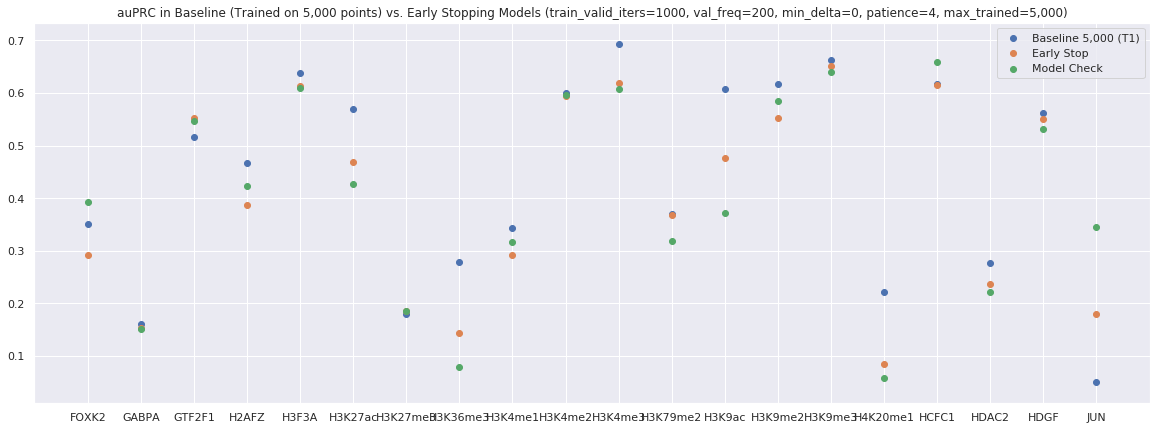

In [69]:
plt.figure(figsize=(20,7))
# df_sub = no_early_results_df.merge(best_param_df, on="transcription_factor", 
#                                    suffixes=('_base', '_idk')).sort_values("transcription_factor")
best_param_df = best_param_df.sort_values("transcription_factor")
early_stop_tfs = best_param_df['transcription_factor']
base_results_df = base_results_df[base_results_df['transcription_factor'].isin(early_stop_tfs)]
base_results_df = base_results_df.sort_values("transcription_factor")
no_early_results_df_5000 = no_early_results_df_5000[
    no_early_results_df_5000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_5000 = no_early_results_df_5000.sort_values('transcription_factor')
no_early_results_df_15000 = no_early_results_df_15000[
    no_early_results_df_15000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_15000 = no_early_results_df_15000.sort_values('transcription_factor')

start_ind, end_ind = 20, 40
x = np.arange(end_ind - start_ind)

# plt.scatter(x, df_sub['auPRC_base'], label= 'Baseline 15,000')
plt.scatter(x, base_results_df['auPRC_earlystop'][start_ind : end_ind], label= 'Baseline 5,000 (T1)')
# plt.scatter(x, no_early_results_df_5000['auPRC'][start_ind : end_ind], label= 'Baseline 5,000 (T2)')
# plt.scatter(x, no_early_results_df_15000['auPRC'][start_ind : end_ind], label= 'Baseline 15,000')
plt.scatter(x, best_param_df['auPRC_earlystop'][start_ind : end_ind], label= 'Early Stop')
plt.scatter(x, best_param_df['auPRC_bestmodel'][start_ind : end_ind], label= 'Model Check')
# plt.scatter(x, best_param_df2['auPRC_earlystop'], label= 'Early Stop 1000, Val Freq 1000')
# plt.scatter(x, best_param_df2['auPRC_bestmodel'], label= 'Model Check 1000, Val Freq 1000')

plt.xticks(x, labels=best_param_df['transcription_factor'][start_ind : end_ind])
plt.title("auPRC in Baseline (Trained on 5,000 points) vs. Early Stopping Models (train_valid_iters=1000, val_freq=200, min_delta=0, patience=4, max_trained=5,000)")
plt.legend();

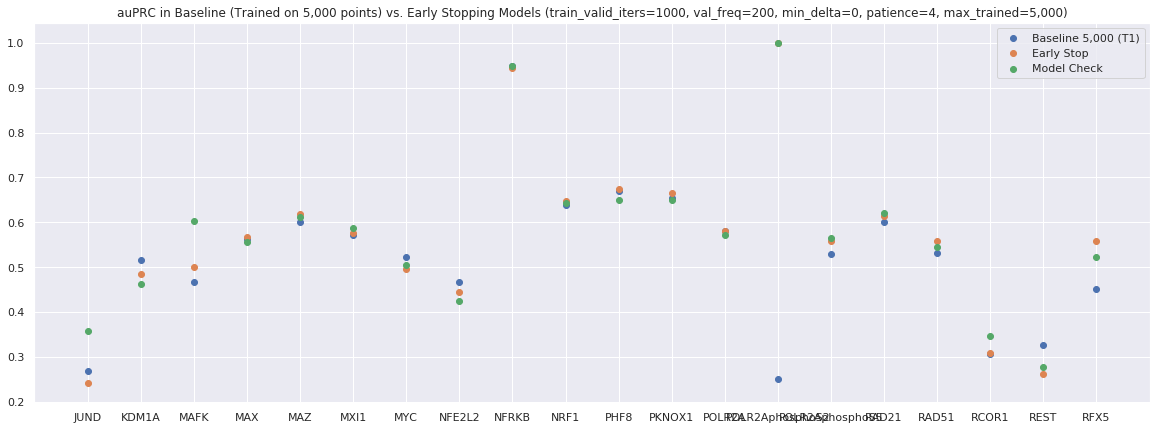

In [72]:
plt.figure(figsize=(20,7))
# df_sub = no_early_results_df.merge(best_param_df, on="transcription_factor", 
#                                    suffixes=('_base', '_idk')).sort_values("transcription_factor")
best_param_df = best_param_df.sort_values("transcription_factor")
early_stop_tfs = best_param_df['transcription_factor']
base_results_df = base_results_df[base_results_df['transcription_factor'].isin(early_stop_tfs)]
base_results_df = base_results_df.sort_values("transcription_factor")
no_early_results_df_5000 = no_early_results_df_5000[
    no_early_results_df_5000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_5000 = no_early_results_df_5000.sort_values('transcription_factor')
no_early_results_df_15000 = no_early_results_df_15000[
    no_early_results_df_15000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_15000 = no_early_results_df_15000.sort_values('transcription_factor')

start_ind, end_ind = 40, 60
x = np.arange(end_ind - start_ind)

# plt.scatter(x, df_sub['auPRC_base'], label= 'Baseline 15,000')
plt.scatter(x, base_results_df['auPRC_earlystop'][start_ind : end_ind], label= 'Baseline 5,000 (T1)')
# plt.scatter(x, no_early_results_df_5000['auPRC'][start_ind : end_ind], label= 'Baseline 5,000 (T2)')
# plt.scatter(x, no_early_results_df_15000['auPRC'][start_ind : end_ind], label= 'Baseline 15,000')
plt.scatter(x, best_param_df['auPRC_earlystop'][start_ind : end_ind], label= 'Early Stop')
plt.scatter(x, best_param_df['auPRC_bestmodel'][start_ind : end_ind], label= 'Model Check')
# plt.scatter(x, best_param_df2['auPRC_earlystop'], label= 'Early Stop 1000, Val Freq 1000')
# plt.scatter(x, best_param_df2['auPRC_bestmodel'], label= 'Model Check 1000, Val Freq 1000')

plt.xticks(x, labels=best_param_df['transcription_factor'][start_ind : end_ind])
plt.title("auPRC in Baseline (Trained on 5,000 points) vs. Early Stopping Models (train_valid_iters=1000, val_freq=200, min_delta=0, patience=4, max_trained=5,000)")
plt.legend();

In [30]:
plt.figure(figsize=(20,7))
# df_sub = no_early_results_df.merge(best_param_df, on="transcription_factor", 
#                                    suffixes=('_base', '_idk')).sort_values("transcription_factor")
best_param_df = best_param_df.sort_values("transcription_factor")
early_stop_tfs = best_param_df['transcription_factor']
base_results_df = base_results_df[base_results_df['transcription_factor'].isin(early_stop_tfs)]
base_results_df = base_results_df.sort_values("transcription_factor")
no_early_results_df_5000 = no_early_results_df_5000[
    no_early_results_df_5000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_5000 = no_early_results_df_5000.sort_values('transcription_factor')
no_early_results_df_15000 = no_early_results_df_15000[
    no_early_results_df_15000['transcription_factor'].isin(early_stop_tfs)]
no_early_results_df_15000 = no_early_results_df_15000.sort_values('transcription_factor')

start_ind, end_ind = 60, 81
x = np.arange(end_ind - start_ind)

# plt.scatter(x, df_sub['auPRC_base'], label= 'Baseline 15,000')
plt.scatter(x, base_results_df['auPRC_earlystop'][start_ind : end_ind], label= 'Baseline 5,000 (T1)')
# plt.scatter(x, no_early_results_df_5000['auPRC'][start_ind : end_ind], label= 'Baseline 5,000 (T2)')
# plt.scatter(x, no_early_results_df_15000['auPRC'][start_ind : end_ind], label= 'Baseline 15,000')
plt.scatter(x, best_param_df['auPRC_earlystop'][start_ind : end_ind], label= 'Early Stop')
plt.scatter(x, best_param_df['auPRC_bestmodel'][start_ind : end_ind], label= 'Model Check')
# plt.scatter(x, best_param_df2['auPRC_earlystop'], label= 'Early Stop 1000, Val Freq 1000')
# plt.scatter(x, best_param_df2['auPRC_bestmodel'], label= 'Model Check 1000, Val Freq 1000')

plt.xticks(x, labels=best_param_df['transcription_factor'][start_ind : end_ind])
plt.title("auPRC in Baseline (Trained on 5,000 points) vs. Early Stopping Models (train_valid_iters=1000, val_freq=200, min_delta=0, patience=4, max_trained=5,000)")
plt.legend();

NameError: name 'no_early_results_df_5000' is not defined

<Figure size 1440x504 with 0 Axes>

In [11]:
# Convert saved string tensors into numerical values
def get_losses(x):
    splt1 = x.split("<tf.Tensor: shape=(), dtype=float32, numpy=")
    splt2 = []
    for s in splt1:
        try:
            splt2.append(float(re.sub("[^0-9.]", "", s)))
        except:
            print(s)
    return splt2

# best_param_sub['valid_losses_conv'] = best_param_sub['valid_losses'].apply(get_losses)

In [36]:
np.linspace(0, 5000, num_epochs+1)

array([   0.,  200.,  400.,  600.,  800., 1000., 1200., 1400., 1600.,
       1800., 2000., 2200., 2400., 2600., 2800., 3000., 3200., 3400.,
       3600., 3800., 4000., 4200., 4400., 4600., 4800., 5000.])

Text(0.5, 1.0, 'Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)')

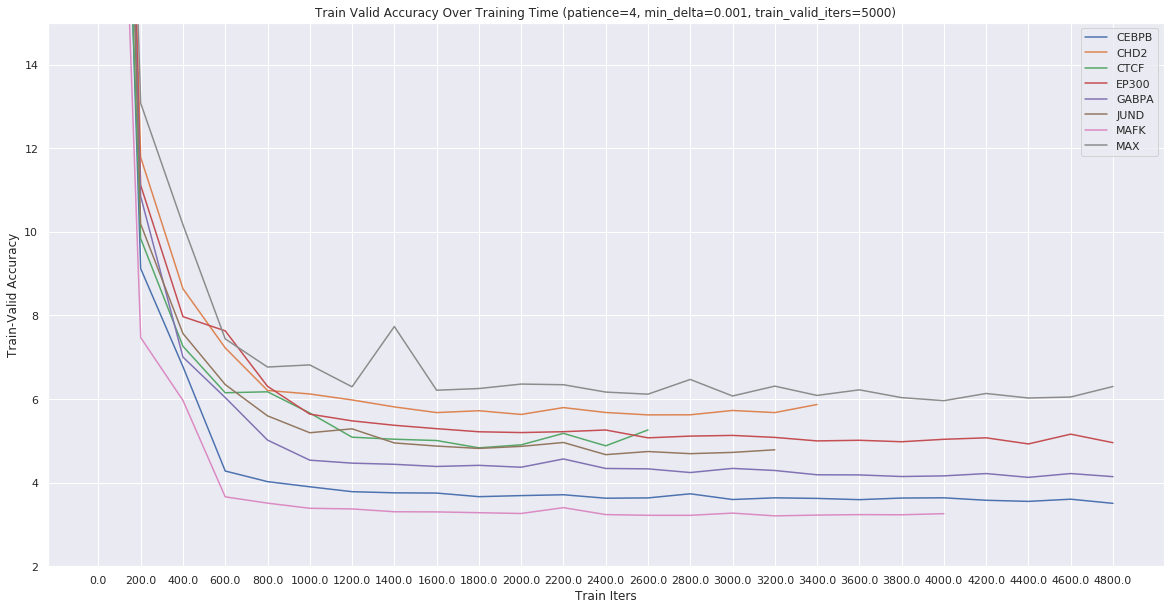

In [152]:
plt.figure(figsize=(20,10))

num_epochs = 25
for i in best_param_sub.index[:8]:
    row = best_param_sub.loc[i]
    row_valid_losses = row['valid_losses_conv']
    plt.plot(np.arange(0, len(row_valid_losses)), row_valid_losses, label=row['transcription_factor'])

plt.legend()
plt.ylim(2, 15)
plt.xlabel("Train Iters")
plt.xticks(np.arange(0, num_epochs), labels=np.linspace(0, 5000, num_epochs+1))
plt.ylabel("Train-Valid Accuracy")
plt.title("Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)")
# best_param_df['transcription_factor']

In [63]:
srf_sub

,transcription_factor,auROC,auPRC,iters_tested,iters_train_valid,iters_trained,min_delta,patience,train_time,valid_losses,...,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq,auPRC_max,valid_losses_conv
0,SRF,NaN,NaN,10000.0,5000.0,NaN,0.1,5.0,9714.630288,"[<tf.Tensor: shape=(), dtype=float32, numpy=42...",...,0.305084,0.429683,0.998743,0.999177,1800.0,5000.0,2800.0,200.0,0.429683,"[42.706818, 10.619363, 5.7853, 4.7220187, 4.36..."
1,SRF,NaN,NaN,10000.0,5000.0,NaN,0.1,5.0,7316.772066,"[<tf.Tensor: shape=(), dtype=float32, numpy=47...",...,0.343292,0.372302,0.998877,0.999032,1000.0,5000.0,2000.0,200.0,0.372302,"[47.022026, 11.451857, 6.7008514, 4.8399725, 4..."
2,SRF,NaN,NaN,10000.0,5000.0,NaN,0.1,5.0,9268.343481,"[<tf.Tensor: shape=(), dtype=float32, numpy=41...",...,0.332920,0.370658,0.998877,0.999032,1600.0,5000.0,2600.0,200.0,0.370658,"[41.624836, 11.35231, 6.6428585, 4.8273, 4.301..."


[
[
[
[49.92285, 10.908066, 6.5041256, 4.979939, 4.3904657, 4.0942984, 4.017737, 4.001805, 4.004426, 3.9886148, 3.9609313, 3.9658024, 3.939288, 3.9328609, 3.9500327, 4.0255384, 3.9322557, 3.893124, 3.8950531, 3.8855867, 3.8635962, 3.892741, 3.8321378, 3.837075, 3.8409543]
[45.003487, 11.818894, 7.2176447, 5.055402, 4.283618, 4.0877337, 4.022947, 4.0227213, 4.0102196, 3.9979026, 3.9616315, 3.9404137, 3.9246962, 3.9165437, 3.8814962, 3.9979398, 3.8990884, 3.8516953, 3.853739, 3.8200243, 3.7843766, 3.7870095, 3.7500515, 3.6781144, 3.6878235]
[44.01382, 11.452214, 7.0001507, 5.192503, 4.540239, 4.12493, 4.020235, 3.9691968, 3.970686, 4.0139327, 3.9869769, 3.9454796, 3.9389, 3.9132724, 3.9066007, 3.9138024, 3.9158843, 3.879689, 3.8720152, 3.8502657, 3.832221, 3.8295753, 3.789029, 3.7676883, 3.7671542]


Text(0.5, 1.0, 'Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)')

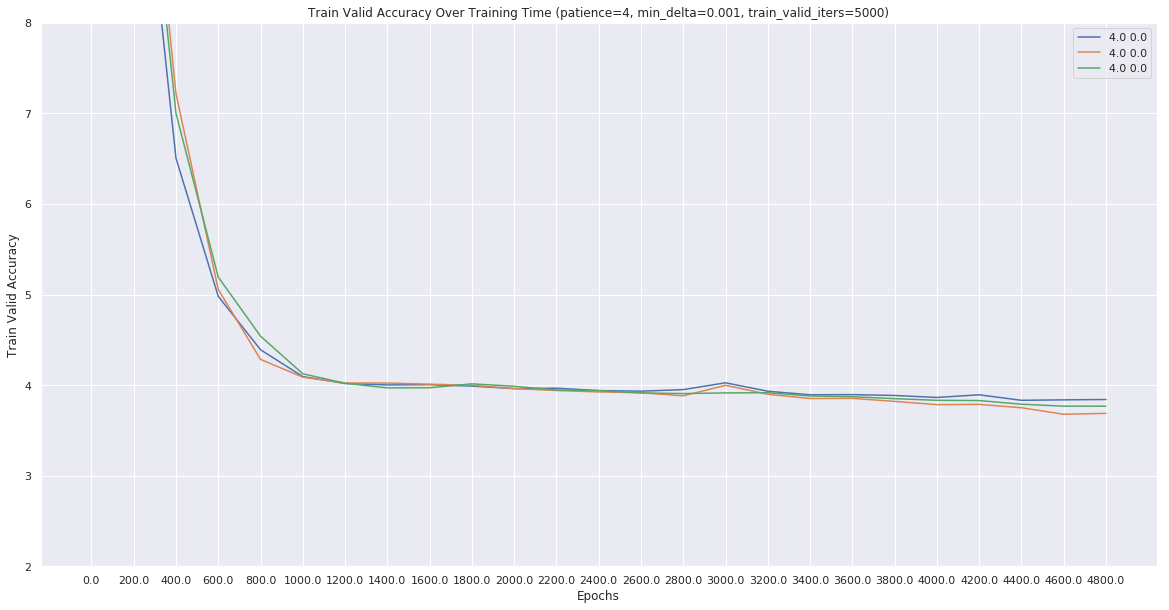

In [28]:
plt.figure(figsize=(20,10))

num_epochs = 25

srf_sub = results_df[(results_df['transcription_factor'] == "SRF") &
                     (results_df['min_delta'] == 0) & 
                     (results_df['patience'] == 4)].reset_index(drop=True)
srf_sub['valid_losses_conv'] = srf_sub['valid_losses'].apply(get_losses)


for i in range(srf_sub.shape[0]):
    row = srf_sub.loc[i]
    row_valid_losses = row['valid_losses_conv']
    print(row_valid_losses)
    plt.plot(np.arange(0, len(row_valid_losses)), row_valid_losses, label= str(row['patience']) + " " + str(row['min_delta']))

plt.legend()
plt.ylim(2,8)
plt.xlabel("Epochs")
plt.xticks(np.arange(0, num_epochs), labels=np.linspace(0, 5000, num_epochs+1))
plt.ylabel("Train Valid Accuracy")
plt.title("Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)")


In [65]:
results_df[(results_df['min_delta'] == 0.1) &
           (results_df['patience'] == 4) & 
        (results_df['transcription_factor'] == "SRF")]


,transcription_factor,auROC,auPRC,iters_tested,iters_train_valid,iters_trained,min_delta,patience,train_time,valid_losses,Unnamed: 0,auPRC_bestmodel,auPRC_earlystop,auROC_bestmodel,auROC_earlystop,iters_trained_bestmodel,iters_trained_max,iters_trained_total,validation_freq,auPRC_max
126,SRF,NaN,NaN,10000.0,5000.0,NaN,0.1,4.0,6583.544933,"[<tf.Tensor: shape=(), dtype=float32, numpy=46...",0.0,0.307858,0.269248,0.998843,0.998732,1000.0,5000.0,1800.0,200.0,0.307858
127,SRF,NaN,NaN,10000.0,5000.0,NaN,0.1,4.0,7893.256525,"[<tf.Tensor: shape=(), dtype=float32, numpy=41...",0.0,0.323684,0.342340,0.998888,0.999010,1400.0,5000.0,2200.0,200.0,0.342340
131,SRF,NaN,NaN,10000.0,5000.0,NaN,0.1,4.0,9352.416760,"[<tf.Tensor: shape=(), dtype=float32, numpy=47...",0.0,0.270834,0.333673,0.998654,0.998943,1800.0,5000.0,2600.0,200.0,0.333673


[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[
[


/home/eecs/jahnavis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Mean Train Valid Loss Over Training Time (for low performing TFs)')

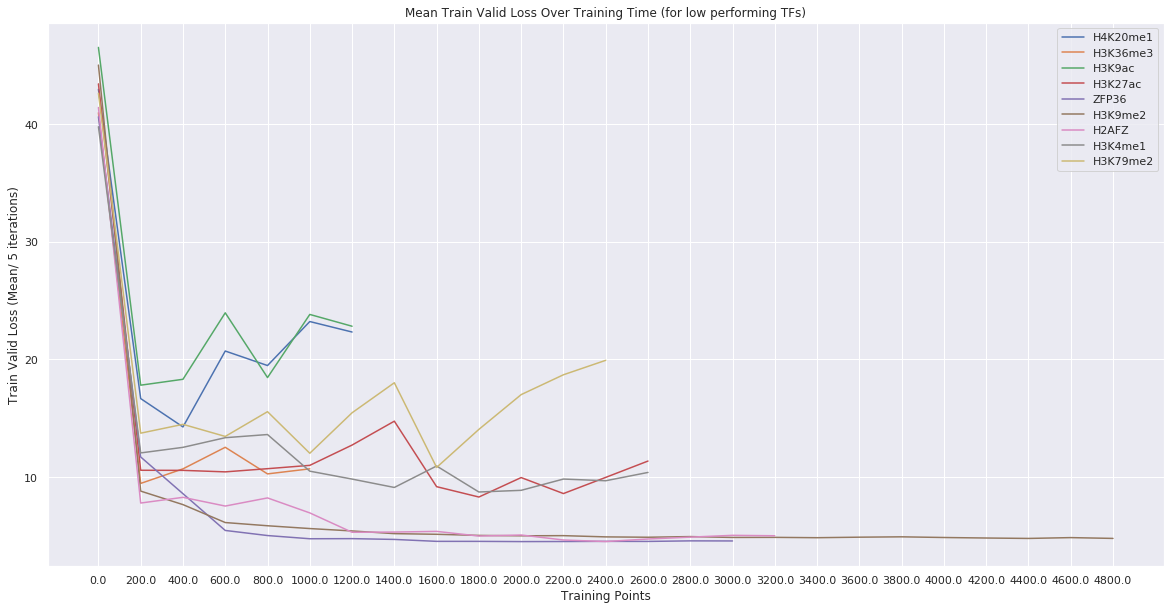

In [31]:
plt.figure(figsize=(20,10))

num_epochs = 25
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)


for curr_tf in low_perf_tfs:
    results_df_sub = results_df[results_df['transcription_factor'] == curr_tf]
    results_df_sub['valid_losses_conv'] = results_df_sub['valid_losses'].apply(get_losses)
    y, error = tolerant_mean(results_df_sub['valid_losses_conv'])
    plt.plot(np.arange(0, len(y)), y, label=curr_tf)

plt.legend()
# plt.ylim(2,10)
plt.xlabel("Training Points")
plt.xticks(np.arange(0, num_epochs), labels=np.linspace(0, 5000, num_epochs+1))
plt.ylabel("Train Valid Loss (Mean/ 5 iterations)")
plt.title("Mean Train Valid Loss Over Training Time (for low performing TFs)")

In [ ]:
plt.figure(figsize=(20,10))

def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

# y, error = tolerant_mean(srf_sub['valid_losses_conv'])

for p in [4]:#results_df['patience'].unique():
    for delt in results_df['min_delta'].unique():
        results_df_sub = results_df[(results_df['min_delta'] == delt) &
                                    (results_df['patience'] == p) & 
                                    (results_df['transcription_factor'] == "SRF")]
        
        results_df_sub['valid_losses_conv'] = results_df_sub['valid_losses'].apply(get_losses)
        
        y, error = tolerant_mean(results_df_sub['valid_losses_conv'])
        plt.plot(np.arange(0, len(y)), y, label= str(p) + " " + str(delt))

plt.legend()
plt.ylim(2,10)
plt.xlabel("Training Points")
plt.xticks(np.arange(0, num_epochs), labels=np.linspace(0, 5000, num_epochs+1))
plt.ylabel("Train Valid Loss (Mean/ 3 iterations)")
plt.title("Mean Train Valid Loss Over Training Time (TF= SRF)")

[
[
[
[
[
[
[
[
[
[
[
[
[
[
[


/home/eecs/jahnavis/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Text(0.5, 1.0, 'Mean Train Valid Loss Over Training Time (TF= RFX5, patience=4, sampled_train_valid_iters=5000, val_freq=200)')

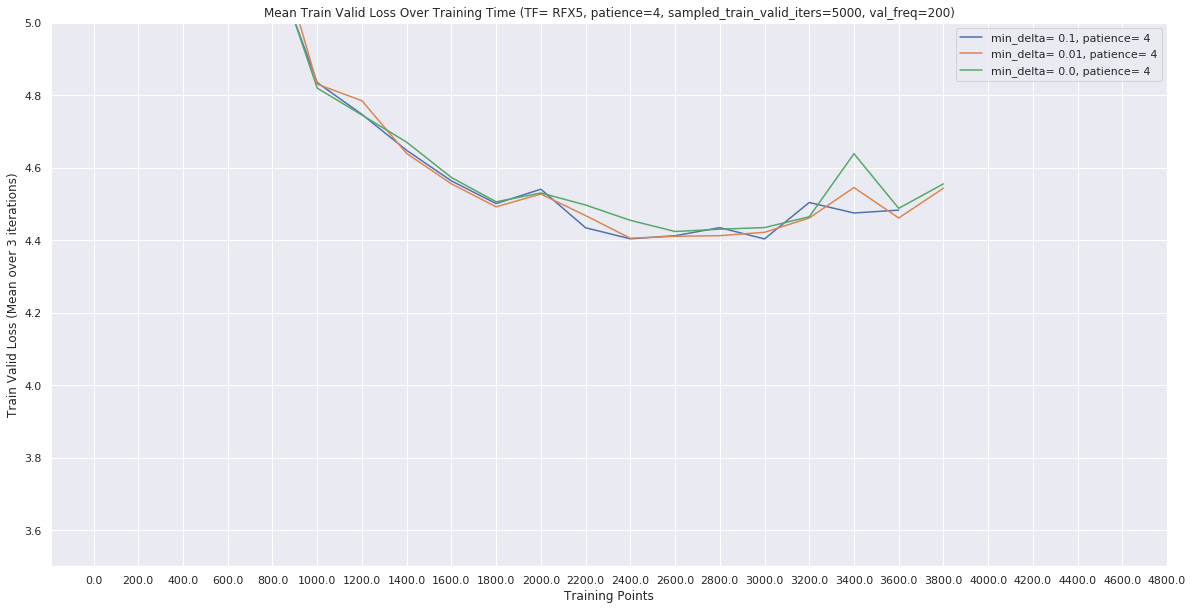

In [24]:
plt.figure(figsize=(20,10))

num_epochs = 25

def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)

# y, error = tolerant_mean(srf_sub['valid_losses_conv'])

for p in [4]:#results_df['patience'].unique():
    for delt in results_df['min_delta'].unique():
        results_df_sub = results_df[(results_df['min_delta'] == delt) &
                                    (results_df['patience'] == p) & 
                                    (results_df['transcription_factor'] == "RFX5")]
        
        results_df_sub['valid_losses_conv'] = results_df_sub['valid_losses'].apply(get_losses)
        
        y, error = tolerant_mean(results_df_sub['valid_losses_conv'])
        plt.plot(np.arange(0, len(y)), y, label= "min_delta= " + str(delt) + ", patience= " + str(p))

plt.legend()
plt.ylim(3.5,5)
plt.xlabel("Training Points")
plt.xticks(np.arange(0, num_epochs), labels=np.linspace(0, 5000, num_epochs+1))
plt.ylabel("Train Valid Loss (Mean over 3 iterations)")
plt.title("Mean Train Valid Loss Over Training Time (TF= RFX5, patience=4, sampled_train_valid_iters=5000, val_freq=200)")

[
[
[
[46.53233, 10.305086, 5.730012, 4.4539557, 4.14719, 4.0146646, 4.0074477, 3.996811, 3.9769633, 3.9693167]
[41.483543, 11.022821, 6.558528, 4.7193995, 4.2045794, 4.0531955, 3.9998837, 3.9520829, 3.9496515, 3.9515226, 3.9283953, 3.9409938]
[47.868294, 10.826923, 6.3231783, 4.787255, 4.361622, 4.1063275, 4.0130844, 4.008986, 4.021246, 3.9879851, 3.9717062, 3.9386954, 3.9332929, 3.936975]


Text(0.5, 1.0, 'Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)')

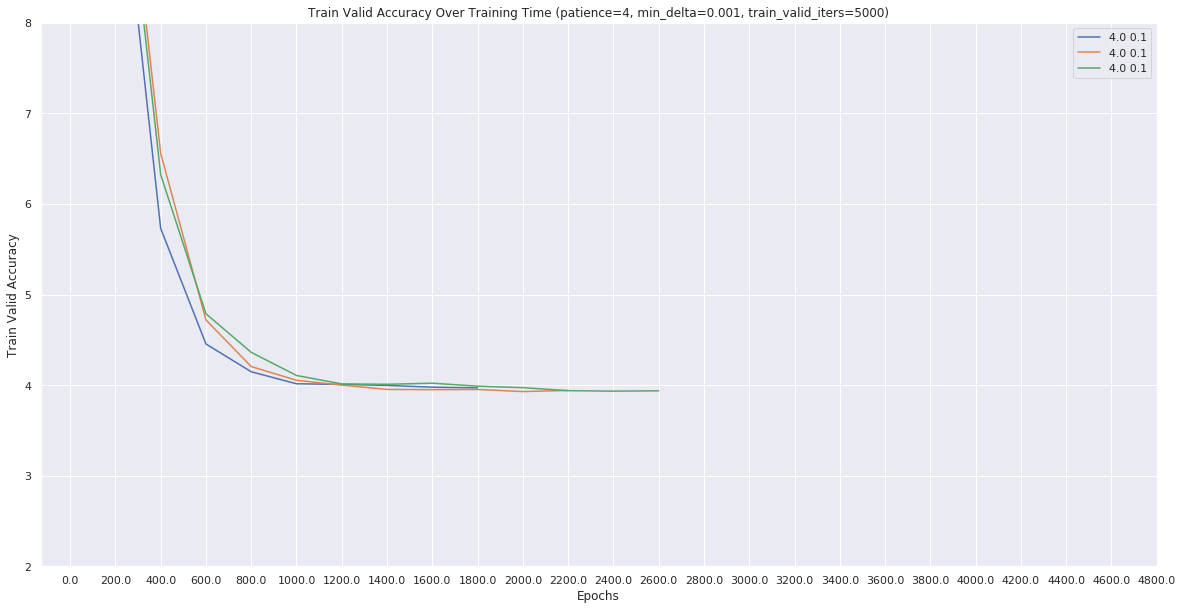

In [35]:
plt.figure(figsize=(20,10))

num_epochs = 25

srf_sub = results_df[(results_df['transcription_factor'] == "SRF") &
                     (results_df['min_delta'] == 0.1) & 
                     (results_df['patience'] == 4)].reset_index(drop=True)

srf_sub['valid_losses_conv'] = srf_sub['valid_losses'].apply(get_losses)


for i in range(srf_sub.shape[0]):
    row = srf_sub.loc[i]
    row_valid_losses = row['valid_losses_conv']
    print(row_valid_losses)
    plt.plot(np.arange(0, len(row_valid_losses)), row_valid_losses, label= str(row['patience']) + " " + str(row['min_delta']))

plt.legend()
plt.ylim(2,8)
plt.xlabel("Epochs")
plt.xticks(np.arange(0, num_epochs), labels=np.linspace(0, 5000, num_epochs+1))
plt.ylabel("Train Valid Accuracy")
plt.title("Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)")


Text(0.5, 1.0, 'Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)')

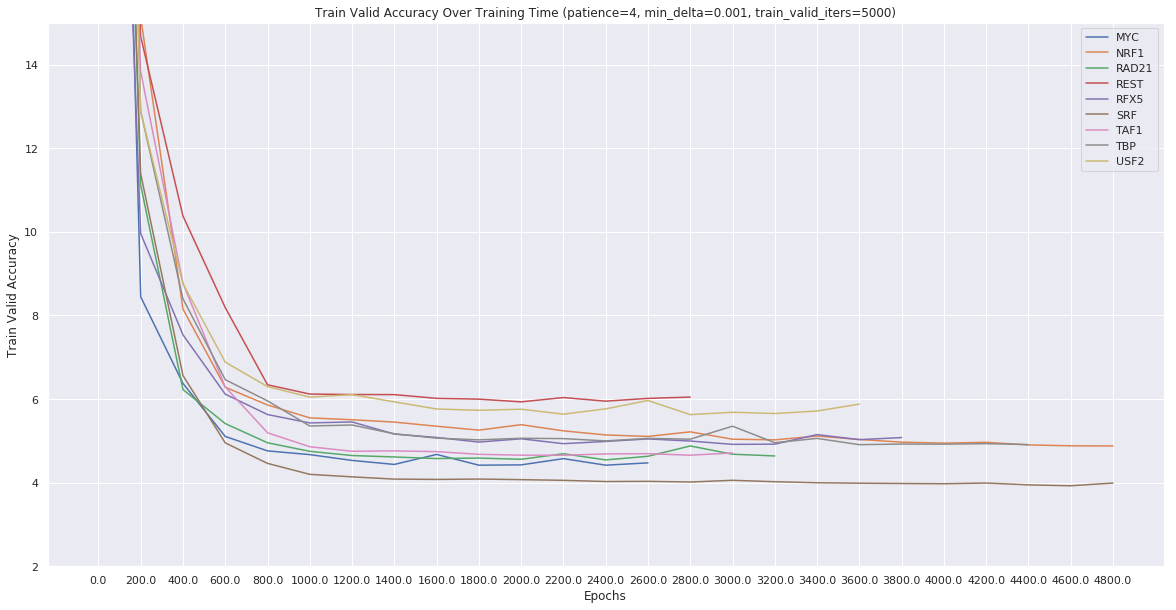

In [151]:
plt.figure(figsize=(20,10))

num_epochs = 25
for i in best_param_sub.index[8:]:
    row = best_param_sub.loc[i]
    row_valid_losses = row['valid_losses_conv']
    plt.plot(np.arange(0, len(row_valid_losses)), row_valid_losses, label=row['transcription_factor'])

plt.legend()
plt.ylim(2,15)
plt.xlabel("Epochs")
plt.xticks(np.arange(0, num_epochs), labels=np.linspace(0, 5000, num_epochs+1))
plt.ylabel("Train Valid Accuracy")
plt.title("Train Valid Accuracy Over Training Time (patience=4, min_delta=0.001, train_valid_iters=5000)")
# best_param_df['transcription_factor']

### Multiple TFs

In [83]:
# Multiple TFs
multi_tf_df = pd.DataFrame(columns =['transcription_factor', 'auROC', 'auPRC', 'iters_tested', 'iters_train_valid', 
                                     'iters_trained', 'min_delta', 'patience', 'train_time'])

internals_results = "results/internals_results/epitome_results/"
for TF_dir in os.listdir(internals_results):
    if (len(TF_dir.split("multi_tf_test_no_motif")) > 1) or (len(TF_dir.split("multi_score")) > 1):
        print(TF_dir)
        full_TF_path = os.path.join(internals_results, TF_dir)
        for p in os.listdir(full_TF_path):
            res_csv = pd.read_csv(os.path.join(full_TF_path, p), sep="\t")
            multi_tf_df = multi_tf_df.append(res_csv, ignore_index=True)

multi_tf_df.shape

multi_tf_test_no_motif_early_stop_15000_train_5000_results
multi_tf_test_no_motif_early_stop_15000_train_1000_results
multi_score_tfs_no_motif_15000_train_results


(9, 10)

In [84]:
multi_tf_df

,transcription_factor,auROC,auPRC,iters_tested,iters_train_valid,iters_trained,min_delta,patience,train_time,Unnamed: 0
0,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.995580,0.624712,10000.0,5000.0,12000.0,0.001,2.0,25278.669272,0.0
1,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.946448,0.336531,10000.0,5000.0,8000.0,0.001,2.0,17612.226834,0.0
2,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.960856,0.376340,10000.0,5000.0,10000.0,0.001,2.0,21956.614682,0.0
3,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.996287,0.633727,10000.0,1000.0,12000.0,0.001,2.0,9622.822154,0.0
4,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.951973,0.364822,10000.0,1000.0,5000.0,0.001,2.0,4504.300138,0.0
5,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.951110,0.361259,10000.0,1000.0,8000.0,0.001,2.0,6777.607222,0.0
6,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.996092,0.633065,10000.0,0.0,15000.0,0.001,2.0,6919.478958,0.0
7,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.967531,0.429881,10000.0,0.0,15000.0,0.001,2.0,7175.684168,0.0
8,"CEBPB, CHD2, CTCF, EP300, GABPA, JUND, MAFK, M...",0.966433,0.446922,10000.0,0.0,15000.0,0.001,2.0,7325.902935,0.0


In [86]:
multi_tf_df.groupby('iters_train_valid')['auPRC'].describe()

,count,mean,std,min,25%,50%,75%,max
iters_train_valid,,,,,,,,
0.0,3.0,0.503289,0.112712,0.429881,0.438401,0.446922,0.539994,0.633065
1000.0,3.0,0.453269,0.156291,0.361259,0.363041,0.364822,0.499275,0.633727
5000.0,3.0,0.445861,0.156163,0.336531,0.356435,0.376340,0.500526,0.624712
